# Skin Lesion Prediction - Modeling
After feature engineering - model definition and training.

* Choose, justify and apply a model performance indicator (e.g. F1 score, true positive rate, within cluster sum of squared error, …) to assess your model and justify the choice of an algorithm
* Implement your algorithm in at least one deep learning and at least one non-deep learning algorithm, compare and document model performance
* Apply at least one additional iteration in the process model involving at least the feature creation task and record impact on model performance (e.g. data normalizing, PCA, …)


### Metric
We have a multiclass classification task so the metric will be *Accuracy.* We will also look at *Precision, Recall/Sensitivity, and Specificity*
This is also a medical classification; *Sensitivity and Specificity* are used for evaluation in this field. 

### Algorithms
Non-Deep Learning:
* 1.Dummy Classifier
* 2.Logistic Regression (Altered for multiclass classification)
* 3.Decision Tree
* 4.Random Forest
* 5.XGBoost Classifier
    
Neural Networks with loss function: (sparse_categorical_crossentropy)
* 1.Single fully connected layer with same number of neurons as the input variables,
     one hidden layer with 512 neurons and softmax output layer.
* 2.Second model is the same as the first with an additional hidden layer of 64 neurons and a dropout           layer at (0.2) 

  

In [37]:
# imports
import numpy as np
import pandas as pd
#!pip install pandas-profiling
import pandas_profiling
from pandas_profiling import ProfileReport
import matplotlib.pyplot as plt
import seaborn as sns
from collections import Counter
from imblearn.over_sampling import SMOTE
import graphviz
%matplotlib inline

np.random.seed(123)

#!pip install scikit-learn
import sklearn
import scikitplot as skplt
import sklearn.feature_selection
from sklearn.preprocessing import label_binarize,OneHotEncoder
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import StratifiedKFold
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline


import tensorflow as tf
import keras
from keras import regularizers
from keras.models import Model
from keras.layers import Input
from keras.layers import Dense, Dropout, Flatten
from keras.layers import Conv2D, MaxPooling2D,AveragePooling2D
from keras.models import Sequential, load_model
from keras.utils.np_utils import to_categorical
from keras.optimizers import RMSprop, Adam
from keras.callbacks import ReduceLROnPlateau
from keras.layers import LeakyReLU
from keras.preprocessing.image import ImageDataGenerator
from keras.layers.normalization import BatchNormalization
from keras.layers.convolutional import SeparableConv2D
from keras.layers.core import Activation
from keras import backend as K
from keras.callbacks import EarlyStopping
from keras.wrappers.scikit_learn import KerasClassifier

## Load dataset

In [59]:
skindf = pd.read_csv('skindf.csv')
skindf.head(3)

,pixel0000,pixel0001,pixel0002,pixel0003,pixel0004,pixel0005,pixel0006,pixel0007,pixel0008,pixel0009,...,pixel2346,pixel2347,pixel2348,pixel2349,pixel2350,pixel2351,label,sex,localization,age
0,192,153,193,195,155,192,197,154,185,202,...,183,147,166,185,154,177,2,0,0,80
1,25,14,30,68,48,75,123,93,126,158,...,25,14,28,25,14,27,2,0,0,80
2,192,138,153,200,145,163,201,142,160,206,...,159,124,142,136,104,117,2,0,0,80


In [60]:
#Split features and targets and make copy of df
X = skindf.drop('label',axis=1).copy() 
y = skindf['label'].copy()

In [61]:
import imblearn
from collections import Counter
print(imblearn.__version__)
counter = Counter(y)
print(counter)

0.7.0
Counter({4: 6705, 6: 1113, 2: 1099, 1: 514, 0: 327, 5: 142, 3: 115})


In [62]:
#Class distributions
import matplotlib.pyplot as pyplot
from imblearn.over_sampling import SMOTE
from sklearn.preprocessing import LabelEncoder

# label encode the target variable
y = LabelEncoder().fit_transform(y)

# summarize distribution
counter = Counter(y)
for k,v in counter.items():
    per = v / len(y) * 100
    print('Class=%d, n=%d (%.3f%%)' % (k, v, per))

Class=2, n=1099 (10.974%)
Class=4, n=6705 (66.950%)
Class=3, n=115 (1.148%)
Class=6, n=1113 (11.113%)
Class=5, n=142 (1.418%)
Class=1, n=514 (5.132%)
Class=0, n=327 (3.265%)


#### Balance the dataset
SMOTE

Note: Not used in first iterations of ML algorithms

In [63]:
#SMOTE
# label encode the target variable
y = LabelEncoder().fit_transform(y)

# transform the dataset
oversample = SMOTE()
X, y = oversample.fit_resample(X, y)

# summarize distribution
counter = Counter(y)
for k,v in counter.items():
    per = v / len(y) * 100
    print('Class=%d, n=%d (%.3f%%)' % (k, v, per))

Class=2, n=6705 (14.286%)
Class=4, n=6705 (14.286%)
Class=3, n=6705 (14.286%)
Class=6, n=6705 (14.286%)
Class=5, n=6705 (14.286%)
Class=1, n=6705 (14.286%)
Class=0, n=6705 (14.286%)


In [64]:
X.shape

(46935, 2355)

In [65]:
y.shape

(46935,)

## Scaling and PCA

In [66]:
# Using 90% for training and 10% for testing
from sklearn.model_selection import train_test_split

X_train,X_test, y_train,y_test = train_test_split(X,y,train_size=0.9,random_state=0)
X_train = X_train.astype('float32')
X_test = X_test.astype('float32')

In [67]:
X_train.shape

(42241, 2355)

In [68]:
X_test.shape

(4694, 2355)

In [69]:
#Standard Scaler
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()

# Fit on training set only.
scaler.fit(X_train)

# Apply transform to both the training set and the test set.
X_train = scaler.transform(X_train)
X_test = scaler.transform(X_test)

In [70]:
#PCA
from sklearn.decomposition import PCA

#Make an instance of the Model
pca = PCA(.95)

In [71]:
#Fit PCA on training set
pca.fit(X_train)

PCA(n_components=0.95)

In [72]:
pca.n_components_

59

In [73]:
#Apply the mapping (transform) to both the training set and the test set
X_train = pca.transform(X_train)
X_test = pca.transform(X_test)

In [74]:
X_test.shape

(4694, 59)

In [75]:
X_train.shape

(42241, 59)

# Model Definition and Training

### Baseline 
#### Dummy Classifier (Imbalanced data)

In [190]:
# Dummy Classifier for baseline 
from sklearn.dummy import DummyClassifier

dummy= DummyClassifier(strategy='stratified',random_state=1)
dummy.fit(X_train,y_train)
 
predicted_dummy= dummy.predict(X_test)

print('Accuracy on train:',dummy.score(X_train,y_train))
print('Accuracy on test:',dummy.score(X_test,y_test))
print('Confusion Matrix:\n{}'.format(confusion_matrix(y_test,predicted_dummy)))

Accuracy on train: 0.47930766670365027
Accuracy on test: 0.4940119760479042
Confusion Matrix:
[[  0   1   1   0  22   1   3]
 [  0   4   3   1  39   0  10]
 [  3   5  11   2  70   1  16]
 [  0   0   2   0   9   0   4]
 [ 19  29  84   5 471  10  60]
 [  0   2   1   0   5   1   5]
 [  1  13  15   0  64   1   8]]


Text(0.5, 15.0, 'Predicted Class')

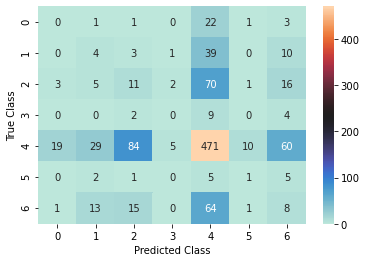

In [191]:
cm = confusion_matrix(y_test,predicted_dummy)

#plt.figure(figsize=(10, 10))
sns.heatmap(cm, annot=True, fmt='g', vmin=0, cbar=True, cmap='icefire')
plt.ylabel('True Class')
plt.xlabel('Predicted Class')

In [192]:
print("dummy:",classification_report(y_test, predicted_dummy))

dummy:               precision    recall  f1-score   support

           0       0.00      0.00      0.00        28
           1       0.07      0.07      0.07        57
           2       0.09      0.10      0.10       108
           3       0.00      0.00      0.00        15
           4       0.69      0.69      0.69       678
           5       0.07      0.07      0.07        14
           6       0.08      0.08      0.08       102

    accuracy                           0.49      1002
   macro avg       0.14      0.15      0.14      1002
weighted avg       0.49      0.49      0.49      1002



In [54]:
# For class label mapping

class_label = {
    0: 'nv',
    1: 'mel',
    2: 'bkl',
    3: 'bcc',
    4: 'akiec',
    5: 'vasc',
    6: 'df'
}

In [194]:
#Performance metrics from confusion matrix 

FP = cm.sum(axis=0) - np.diag(cm) 
FN = cm.sum(axis=1) - np.diag(cm)
TP = np.diag(cm)
TN = cm.sum() - (FP + FN + TP)

FP = FP.astype(float)
FN = FN.astype(float)
TP = TP.astype(float)
TN = TN.astype(float)

# Sensitivity, hit rate, Recall, or true positive rate
TPR = TP/(TP+FN)

# Specificity or true negative rate
TNR = TN/(TN+FP) 

# Precision or positive predictive value
PPV = TP/(TP+FP)

# Negative predictive value
NPV = TN/(TN+FN)

# Fall out or false positive rate
FPR = FP/(FP+TN)

# False negative rate
FNR = FN/(TP+FN)

# False discovery rate
FDR = FP/(TP+FP)


print('Class:',class_label)

print('Specificity:',TNR)
print('Specificity Mean:',TNR.mean())

print('Class:',class_label)

print('Recall/Sensitivity:',TPR)
print('Recall/Sensitivity Mean:',TPR.mean())

print('Class:',class_label)

print('Precision:',PPV)
print('Precision Mean:',PPV.mean())


Class: {0: 'nv', 1: 'mel', 2: 'bkl', 3: 'bcc', 4: 'akiec', 5: 'vasc', 6: 'df'}
Specificity: [0.97638604 0.94708995 0.88143177 0.99189463 0.35493827 0.98684211
 0.89111111]
Specificity Mean: 0.8613848385086357
Class: {0: 'nv', 1: 'mel', 2: 'bkl', 3: 'bcc', 4: 'akiec', 5: 'vasc', 6: 'df'}
Recall/Sensitivity: [0.         0.07017544 0.10185185 0.         0.69469027 0.07142857
 0.07843137]
Recall/Sensitivity Mean: 0.14522535713037996
Class: {0: 'nv', 1: 'mel', 2: 'bkl', 3: 'bcc', 4: 'akiec', 5: 'vasc', 6: 'df'}
Precision: [0.         0.07407407 0.09401709 0.         0.69264706 0.07142857
 0.0754717 ]
Precision Mean: 0.1439483566366395


### Dummy Classifier (Balanced data)

In [116]:
# Dummy Classifier for baseline 
from sklearn.dummy import DummyClassifier

dummy= DummyClassifier(strategy='stratified',random_state=1)
dummy.fit(X_train,y_train)
 
predicted_dummy= dummy.predict(X_test)

#print('Accuracy on train:',dummy.score(X_train,y_train))
print('Accuracy on test:',dummy.score(X_test,y_test))
print('Confusion Matrix:\n{}'.format(confusion_matrix(y_test,predicted_dummy)))

Accuracy on test: 0.14507882403067746
Confusion Matrix:
[[ 95  97  92 108  79 102  92]
 [106 109  93 106  96  76  90]
 [ 85  96 102  85  84 109 109]
 [ 90  91 104  75  80  94  87]
 [106  80 101 101  94 103 110]
 [107  96 101 106 100 100  95]
 [103  83  91  91  90  98 106]]


Text(0.5, 15.0, 'Predicted Class')

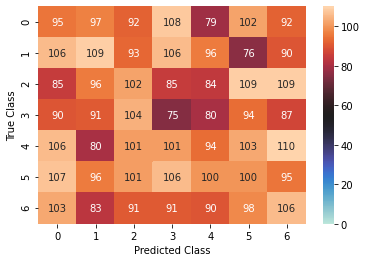

In [117]:
cm = confusion_matrix(y_test,predicted_dummy)

#plt.figure(figsize=(10, 10))
sns.heatmap(cm, annot=True, fmt='g', vmin=0, cbar=True, cmap='icefire')
plt.ylabel('True Class')
plt.xlabel('Predicted Class')

In [118]:
print("dummy:",classification_report(y_test, predicted_dummy))

dummy:               precision    recall  f1-score   support

           0       0.14      0.14      0.14       665
           1       0.17      0.16      0.16       676
           2       0.15      0.15      0.15       670
           3       0.11      0.12      0.12       621
           4       0.15      0.14      0.14       695
           5       0.15      0.14      0.14       705
           6       0.15      0.16      0.16       662

    accuracy                           0.15      4694
   macro avg       0.15      0.14      0.14      4694
weighted avg       0.15      0.15      0.15      4694



In [119]:
# For class label mapping

class_label = {
    0: 'nv',
    1: 'mel',
    2: 'bkl',
    3: 'bcc',
    4: 'akiec',
    5: 'vasc',
    6: 'df'
}

In [120]:
#Performance metrics from confusion matrix 

FP = cm.sum(axis=0) - np.diag(cm) 
FN = cm.sum(axis=1) - np.diag(cm)
TP = np.diag(cm)
TN = cm.sum() - (FP + FN + TP)

FP = FP.astype(float)
FN = FN.astype(float)
TP = TP.astype(float)
TN = TN.astype(float)

# Sensitivity, hit rate, Recall, or true positive rate
TPR = TP/(TP+FN)

# Specificity or true negative rate
TNR = TN/(TN+FP) 

# Precision or positive predictive value
PPV = TP/(TP+FP)

# Negative predictive value
NPV = TN/(TN+FN)

# Fall out or false positive rate
FPR = FP/(FP+TN)

# False negative rate
FNR = FN/(TP+FN)

# False discovery rate
FDR = FP/(TP+FP)


print('Class:',class_label)

print('Specificity:',TNR)
print('Specificity Mean:',TNR.mean())

print('Class:',class_label)

print('Recall/Sensitivity:',TPR)
print('Recall/Sensitivity Mean:',TPR.mean())

print('Class:',class_label)

print('Precision:',PPV)
print('Precision Mean:',PPV.mean())

Class: {0: 'nv', 1: 'mel', 2: 'bkl', 3: 'bcc', 4: 'akiec', 5: 'vasc', 6: 'df'}
Specificity: [0.85182427 0.86485814 0.85536779 0.85342499 0.86771693 0.85409877
 0.85540675]
Specificity Mean: 0.857528235197042
Class: {0: 'nv', 1: 'mel', 2: 'bkl', 3: 'bcc', 4: 'akiec', 5: 'vasc', 6: 'df'}
Recall/Sensitivity: [0.14285714 0.1612426  0.15223881 0.12077295 0.1352518  0.14184397
 0.16012085]
Recall/Sensitivity Mean: 0.1449040164787569
Class: {0: 'nv', 1: 'mel', 2: 'bkl', 3: 'bcc', 4: 'akiec', 5: 'vasc', 6: 'df'}
Precision: [0.13728324 0.16717791 0.14912281 0.11160714 0.15088283 0.14662757
 0.15384615]
Precision Mean: 0.14522109226400323


## Logistic Regression (Imbalanced data)

In [195]:
#Altered for multiclass classification
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score,f1_score

lr = LogisticRegression(n_jobs=-1,multi_class='multinomial', solver='lbfgs').fit(X_train,y_train)
#Added: multi_class='multinomial', solver='lbfgs'

pred_lr= lr.predict(X_test)
pred2= lr.predict(X_train)
print("Accuracy on train: {:.3f}".format(accuracy_score(y_train,pred2)))
print("Accuracy on test: {:.3f}".format(accuracy_score(y_test,pred_lr)))
print('Confusion Matrix:\n{}'.format(confusion_matrix(y_test,pred_lr)))

Accuracy on train: 0.715
Accuracy on test: 0.690
Confusion Matrix:
[[  3   6   5   0  14   0   0]
 [  1  23   4   0  26   2   1]
 [  0   4  35   0  57   0  12]
 [  1   5   4   0   5   0   0]
 [  2   5  30   0 617   1  23]
 [  1   5   1   0   4   3   0]
 [  0   2  15   0  74   1  10]]


In [196]:
print("lr:",classification_report(y_test, pred_lr))

lr:               precision    recall  f1-score   support

           0       0.38      0.11      0.17        28
           1       0.46      0.40      0.43        57
           2       0.37      0.32      0.35       108
           3       0.00      0.00      0.00        15
           4       0.77      0.91      0.84       678
           5       0.43      0.21      0.29        14
           6       0.22      0.10      0.14       102

    accuracy                           0.69      1002
   macro avg       0.38      0.29      0.31      1002
weighted avg       0.63      0.69      0.65      1002



C:\Users\celie\Anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\celie\Anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\celie\Anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Text(0.5, 15.0, 'Predicted Class')

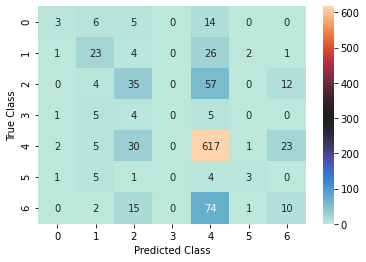

In [197]:
cm = confusion_matrix(y_test,pred_lr)
#sns.heatmap(cm, annot=True)
sns.heatmap(cm, annot=True, fmt='g', vmin=0, cbar=True, cmap='icefire') #removed 'crest_r'
plt.ylabel('True Class')
plt.xlabel('Predicted Class')

In [198]:
#Performance metrics from confusion matrix 

FP = cm.sum(axis=0) - np.diag(cm) 
FN = cm.sum(axis=1) - np.diag(cm)
TP = np.diag(cm)
TN = cm.sum() - (FP + FN + TP)

FP = FP.astype(float)
FN = FN.astype(float)
TP = TP.astype(float)
TN = TN.astype(float)

# Sensitivity, hit rate, Recall, or true positive rate
TPR = TP/(TP+FN)

# Specificity or true negative rate
TNR = TN/(TN+FP) 

# Precision or positive predictive value
PPV = TP/(TP+FP)

# Negative predictive value
NPV = TN/(TN+FN)

# Fall out or false positive rate
FPR = FP/(FP+TN)

# False negative rate
FNR = FN/(TP+FN)

# False discovery rate
FDR = FP/(TP+FP)


print('Class:',class_label)

print('Specificity:',TNR)
print('Specificity Mean:',TNR.mean())

print('Class:',class_label)

print('Recall/Sensitivity:',TPR)
print('Recall/Sensitivity Mean:',TPR.mean())

print('Class:',class_label)

print('Precision:',PPV)
print('Precision Mean:',PPV.mean())

Class: {0: 'nv', 1: 'mel', 2: 'bkl', 3: 'bcc', 4: 'akiec', 5: 'vasc', 6: 'df'}
Specificity: [0.99486653 0.97142857 0.93400447 1.         0.44444444 0.99595142
 0.96      ]
Specificity Mean: 0.9000993481320175
Class: {0: 'nv', 1: 'mel', 2: 'bkl', 3: 'bcc', 4: 'akiec', 5: 'vasc', 6: 'df'}
Recall/Sensitivity: [0.10714286 0.40350877 0.32407407 0.         0.9100295  0.21428571
 0.09803922]
Recall/Sensitivity Mean: 0.29386859023483114
Class: {0: 'nv', 1: 'mel', 2: 'bkl', 3: 'bcc', 4: 'akiec', 5: 'vasc', 6: 'df'}
Precision: [0.375      0.46       0.37234043        nan 0.77415307 0.42857143
 0.2173913 ]
Precision Mean: nan


C:\Users\celie\Anaconda3\lib\site-packages\ipykernel_launcher.py:20: RuntimeWarning: invalid value encountered in true_divide
C:\Users\celie\Anaconda3\lib\site-packages\ipykernel_launcher.py:32: RuntimeWarning: invalid value encountered in true_divide


## Logistic Regression (Balanced data)

In [123]:
#Altered for multiclass classification
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score,f1_score

lr = LogisticRegression(n_jobs=-1,multi_class='multinomial', solver='lbfgs').fit(X_train,y_train)
#Added: multi_class='multinomial', solver='lbfgs'

pred_lr= lr.predict(X_test)
pred2= lr.predict(X_train)
print("Accuracy on train: {:.3f}".format(accuracy_score(y_train,pred2)))
print("Accuracy on test: {:.3f}".format(accuracy_score(y_test,pred_lr)))
print('Confusion Matrix:\n{}'.format(confusion_matrix(y_test,pred_lr)))

Accuracy on train: 0.639
Accuracy on test: 0.645
Confusion Matrix:
[[418  74  52  79  16  12  14]
 [ 78 429  47  54  13  47   8]
 [ 78  41 330  20  68  18 115]
 [ 32  32  12 453  43  20  29]
 [ 38  21  59  34 406  28 109]
 [ 46  30   3   7  11 605   3]
 [ 18  17 112  29  80  21 385]]


In [124]:
print("lr:",classification_report(y_test, pred_lr))

lr:               precision    recall  f1-score   support

           0       0.59      0.63      0.61       665
           1       0.67      0.63      0.65       676
           2       0.54      0.49      0.51       670
           3       0.67      0.73      0.70       621
           4       0.64      0.58      0.61       695
           5       0.81      0.86      0.83       705
           6       0.58      0.58      0.58       662

    accuracy                           0.64      4694
   macro avg       0.64      0.64      0.64      4694
weighted avg       0.64      0.64      0.64      4694



Text(0.5, 15.0, 'Predicted Class')

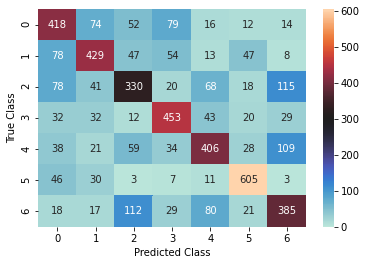

In [125]:
cm = confusion_matrix(y_test,pred_lr)
#sns.heatmap(cm, annot=True)
sns.heatmap(cm, annot=True, fmt='g', vmin=0, cbar=True, cmap='icefire') #removed 'crest_r'
plt.ylabel('True Class')
plt.xlabel('Predicted Class')

In [126]:
#Performance metrics from confusion matrix 

FP = cm.sum(axis=0) - np.diag(cm) 
FN = cm.sum(axis=1) - np.diag(cm)
TP = np.diag(cm)
TN = cm.sum() - (FP + FN + TP)

FP = FP.astype(float)
FN = FN.astype(float)
TP = TP.astype(float)
TN = TN.astype(float)

# Sensitivity, hit rate, Recall, or true positive rate
TPR = TP/(TP+FN)

# Specificity or true negative rate
TNR = TN/(TN+FP) 

# Precision or positive predictive value
PPV = TP/(TP+FP)

# Negative predictive value
NPV = TN/(TN+FN)

# Fall out or false positive rate
FPR = FP/(FP+TN)

# False negative rate
FNR = FN/(TP+FN)

# False discovery rate
FDR = FP/(TP+FP)


print('Class:',class_label)

print('Specificity:',TNR)
print('Specificity Mean:',TNR.mean())

print('Class:',class_label)

print('Recall/Sensitivity:',TPR)
print('Recall/Sensitivity Mean:',TPR.mean())

print('Class:',class_label)

print('Precision:',PPV)
print('Precision Mean:',PPV.mean())

Class: {0: 'nv', 1: 'mel', 2: 'bkl', 3: 'bcc', 4: 'akiec', 5: 'vasc', 6: 'df'}
Specificity: [0.92802184 0.94649079 0.92917495 0.9452492  0.94223556 0.96339935
 0.93105159]
Specificity Mean: 0.9408033256922902
Class: {0: 'nv', 1: 'mel', 2: 'bkl', 3: 'bcc', 4: 'akiec', 5: 'vasc', 6: 'df'}
Recall/Sensitivity: [0.62857143 0.63461538 0.49253731 0.7294686  0.58417266 0.85815603
 0.581571  ]
Recall/Sensitivity Mean: 0.6441560589816593
Class: {0: 'nv', 1: 'mel', 2: 'bkl', 3: 'bcc', 4: 'akiec', 5: 'vasc', 6: 'df'}
Precision: [0.59039548 0.66614907 0.53658537 0.67011834 0.63736264 0.80559254
 0.58069382]
Precision Mean: 0.6409853220320141


## Decision Tree (imbalanced data)

In [27]:
from sklearn.metrics import f1_score
from sklearn.tree import DecisionTreeClassifier
dt = DecisionTreeClassifier(random_state=0).fit(X_train,y_train)
pred_dt = dt.predict(X_test)
pred2 = dt.predict(X_train)
print("Accuracy on train: {:.3f}".format(accuracy_score(y_train,pred2)))
print("Accuracy on test: {:.3f}".format(accuracy_score(y_test,pred_dt)))
print('Confusion Matrix:\n{}'.format(confusion_matrix(y_test,pred_dt)))

Accuracy on train: 1.000
Accuracy on test: 0.629
Confusion Matrix:
[[  3   5   6   1   9   3   1]
 [ 10  15   9   1  14   2   6]
 [  8   9  33   0  39   0  19]
 [  2   4   2   1   5   1   0]
 [  7  10  38   3 549  12  59]
 [  0   3   1   0   5   2   3]
 [  2   4  23   0  45   1  27]]


In [28]:
print("dt:",classification_report(y_test, pred_dt))

dt:               precision    recall  f1-score   support

           0       0.09      0.11      0.10        28
           1       0.30      0.26      0.28        57
           2       0.29      0.31      0.30       108
           3       0.17      0.07      0.10        15
           4       0.82      0.81      0.82       678
           5       0.10      0.14      0.11        14
           6       0.23      0.26      0.25       102

    accuracy                           0.63      1002
   macro avg       0.29      0.28      0.28      1002
weighted avg       0.64      0.63      0.63      1002



Text(0.5, 15.0, 'Predicted Class')

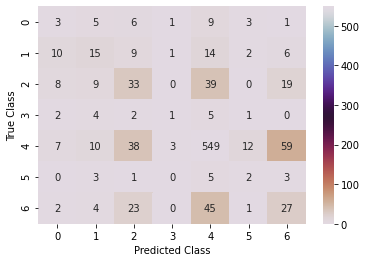

In [29]:
cm = confusion_matrix(y_test,pred_dt)
#sns.heatmap(cm, annot=True)
sns.heatmap(cm, annot=True, fmt='g', vmin=0, cbar=True, cmap='twilight_r')
plt.ylabel('True Class')
plt.xlabel('Predicted Class')

In [30]:
#Performance metrics from confusion matrix 

FP = cm.sum(axis=0) - np.diag(cm) 
FN = cm.sum(axis=1) - np.diag(cm)
TP = np.diag(cm)
TN = cm.sum() - (FP + FN + TP)

FP = FP.astype(float)
FN = FN.astype(float)
TP = TP.astype(float)
TN = TN.astype(float)

# Sensitivity, hit rate, Recall, or true positive rate
TPR = TP/(TP+FN)

# Specificity or true negative rate
TNR = TN/(TN+FP) 

# Precision or positive predictive value
PPV = TP/(TP+FP)

# Negative predictive value
NPV = TN/(TN+FN)

# Fall out or false positive rate
FPR = FP/(FP+TN)

# False negative rate
FNR = FN/(TP+FN)

# False discovery rate
FDR = FP/(TP+FP)


print('Class:',class_label)

print('Specificity:',TNR)
print('Specificity Mean:',TNR.mean())

print('Class:',class_label)

print('Recall/Sensitivity:',TPR)
print('Recall/Sensitivity Mean:',TPR.mean())

print('Class:',class_label)

print('Precision:',PPV)
print('Precision Mean:',PPV.mean())

Class: {0: 'nv', 1: 'mel', 2: 'bkl', 3: 'bcc', 4: 'akiec', 5: 'vasc', 6: 'df'}
Specificity: [0.97022587 0.96296296 0.91163311 0.99493414 0.63888889 0.98076923
 0.90222222]
Specificity Mean: 0.908805204431892
Class: {0: 'nv', 1: 'mel', 2: 'bkl', 3: 'bcc', 4: 'akiec', 5: 'vasc', 6: 'df'}
Recall/Sensitivity: [0.10714286 0.26315789 0.30555556 0.06666667 0.80973451 0.14285714
 0.26470588]
Recall/Sensitivity Mean: 0.27997435894090594
Class: {0: 'nv', 1: 'mel', 2: 'bkl', 3: 'bcc', 4: 'akiec', 5: 'vasc', 6: 'df'}
Precision: [0.09375    0.3        0.29464286 0.16666667 0.82432432 0.0952381
 0.23478261]
Precision Mean: 0.2870577931525137


## Decision Tree (Balanced data)

In [127]:
from sklearn.metrics import f1_score
from sklearn.tree import DecisionTreeClassifier
dt = DecisionTreeClassifier(random_state=0).fit(X_train,y_train)
pred_dt = dt.predict(X_test)
pred2 = dt.predict(X_train)
print("Accuracy on train: {:.3f}".format(accuracy_score(y_train,pred2)))
print("Accuracy on test: {:.3f}".format(accuracy_score(y_test,pred_dt)))
print('Confusion Matrix:\n{}'.format(confusion_matrix(y_test,pred_dt)))

Accuracy on train: 1.000
Accuracy on test: 0.846
Confusion Matrix:
[[598  18  14   7  12   3  13]
 [ 22 586  22   6  22   8  10]
 [ 23  18 529   6  48   5  41]
 [  3   2   1 604   8   3   0]
 [ 23  36  69  19 447  13  88]
 [  3   8   3   1  13 673   4]
 [  8  12  38   6  55   8 535]]


In [128]:
print("dt:",classification_report(y_test, pred_dt))

dt:               precision    recall  f1-score   support

           0       0.88      0.90      0.89       665
           1       0.86      0.87      0.86       676
           2       0.78      0.79      0.79       670
           3       0.93      0.97      0.95       621
           4       0.74      0.64      0.69       695
           5       0.94      0.95      0.95       705
           6       0.77      0.81      0.79       662

    accuracy                           0.85      4694
   macro avg       0.84      0.85      0.85      4694
weighted avg       0.84      0.85      0.84      4694



Text(0.5, 15.0, 'Predicted Class')

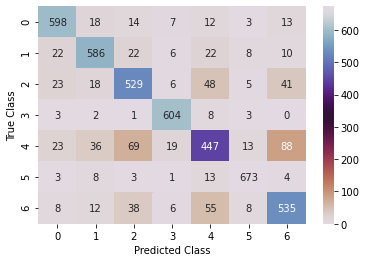

In [129]:
cm = confusion_matrix(y_test,pred_dt)
#sns.heatmap(cm, annot=True)
sns.heatmap(cm, annot=True, fmt='g', vmin=0, cbar=True, cmap='twilight_r')
plt.ylabel('True Class')
plt.xlabel('Predicted Class')

In [130]:
#Performance metrics from confusion matrix 

FP = cm.sum(axis=0) - np.diag(cm) 
FN = cm.sum(axis=1) - np.diag(cm)
TP = np.diag(cm)
TN = cm.sum() - (FP + FN + TP)

FP = FP.astype(float)
FN = FN.astype(float)
TP = TP.astype(float)
TN = TN.astype(float)

# Sensitivity, hit rate, Recall, or true positive rate
TPR = TP/(TP+FN)

# Specificity or true negative rate
TNR = TN/(TN+FP) 

# Precision or positive predictive value
PPV = TP/(TP+FP)

# Negative predictive value
NPV = TN/(TN+FN)

# Fall out or false positive rate
FPR = FP/(FP+TN)

# False negative rate
FNR = FN/(TP+FN)

# False discovery rate
FDR = FP/(TP+FP)


print('Class:',class_label)

print('Specificity:',TNR)
print('Specificity Mean:',TNR.mean())

print('Class:',class_label)

print('Recall/Sensitivity:',TPR)
print('Recall/Sensitivity Mean:',TPR.mean())

print('Class:',class_label)

print('Precision:',PPV)
print('Precision Mean:',PPV.mean())

Class: {0: 'nv', 1: 'mel', 2: 'bkl', 3: 'bcc', 4: 'akiec', 5: 'vasc', 6: 'df'}
Specificity: [0.97964756 0.97660528 0.96346918 0.98895163 0.96049012 0.98997242
 0.96130952]
Specificity Mean: 0.9743493885117004
Class: {0: 'nv', 1: 'mel', 2: 'bkl', 3: 'bcc', 4: 'akiec', 5: 'vasc', 6: 'df'}
Recall/Sensitivity: [0.89924812 0.86686391 0.78955224 0.9726248  0.64316547 0.95460993
 0.8081571 ]
Recall/Sensitivity Mean: 0.8477459370779599
Class: {0: 'nv', 1: 'mel', 2: 'bkl', 3: 'bcc', 4: 'akiec', 5: 'vasc', 6: 'df'}
Precision: [0.87941176 0.86176471 0.78254438 0.93066256 0.73884298 0.94389902
 0.77424023]
Precision Mean: 0.8444808045793676


## Random Forest Classifier (Imbalanced data)

In [31]:
from sklearn.ensemble import RandomForestClassifier
rf = RandomForestClassifier(n_estimators=10,n_jobs=-1,criterion='gini')# removed , oob_score=True for too few estimators
rf.fit(X_train,y_train)
pred_rf= rf.predict(X_test)
pred2= rf.predict(X_train)
print("Accuracy on train: {:.3f}".format(accuracy_score(y_train,pred2)))
print("Accuracy on test: {:.3f}".format(accuracy_score(y_test,pred_rf)))
print('Confusion Matrix:\n{}'.format(confusion_matrix(y_test,pred_rf)))

Accuracy on train: 0.992
Accuracy on test: 0.681
Confusion Matrix:
[[  2   4   8   0  14   0   0]
 [  8  12  13   1  22   0   1]
 [  2   6  24   0  68   0   8]
 [  2   3   1   0   8   0   1]
 [  2   5  29   0 623   0  19]
 [  2   0   1   0  10   1   0]
 [  4   0   6   0  72   0  20]]


In [32]:
print("rf:",classification_report(y_test, pred_rf))

rf:               precision    recall  f1-score   support

           0       0.09      0.07      0.08        28
           1       0.40      0.21      0.28        57
           2       0.29      0.22      0.25       108
           3       0.00      0.00      0.00        15
           4       0.76      0.92      0.83       678
           5       1.00      0.07      0.13        14
           6       0.41      0.20      0.26       102

    accuracy                           0.68      1002
   macro avg       0.42      0.24      0.26      1002
weighted avg       0.63      0.68      0.64      1002



Text(0.5, 15.0, 'Predicted Class')

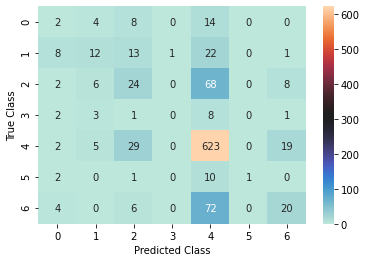

In [33]:
cm = confusion_matrix(y_test,pred_rf)
#sns.heatmap(cm, annot=True)
sns.heatmap(cm, annot=True, fmt='g', vmin=0, cbar=True, cmap='icefire')
plt.ylabel('True Class')
plt.xlabel('Predicted Class')

In [34]:
#Performance metrics from confusion matrix 

FP = cm.sum(axis=0) - np.diag(cm) 
FN = cm.sum(axis=1) - np.diag(cm)
TP = np.diag(cm)
TN = cm.sum() - (FP + FN + TP)

FP = FP.astype(float)
FN = FN.astype(float)
TP = TP.astype(float)
TN = TN.astype(float)

# Sensitivity, hit rate, Recall, or true positive rate
TPR = TP/(TP+FN)

# Specificity or true negative rate
TNR = TN/(TN+FP) 

# Precision or positive predictive value
PPV = TP/(TP+FP)

# Negative predictive value
NPV = TN/(TN+FN)

# Fall out or false positive rate
FPR = FP/(FP+TN)

# False negative rate
FNR = FN/(TP+FN)

# False discovery rate
FDR = FP/(TP+FP)


print('Class:',class_label)

print('Specificity:',TNR)
print('Specificity Mean:',TNR.mean())

print('Class:',class_label)

print('Recall/Sensitivity:',TPR)
print('Recall/Sensitivity Mean:',TPR.mean())

print('Class:',class_label)

print('Precision:',PPV)
print('Precision Mean:',PPV.mean())

Class: {0: 'nv', 1: 'mel', 2: 'bkl', 3: 'bcc', 4: 'akiec', 5: 'vasc', 6: 'df'}
Specificity: [0.97946612 0.98095238 0.93512304 0.99898683 0.40123457 1.
 0.96777778]
Specificity Mean: 0.8947915310010798
Class: {0: 'nv', 1: 'mel', 2: 'bkl', 3: 'bcc', 4: 'akiec', 5: 'vasc', 6: 'df'}
Recall/Sensitivity: [0.07142857 0.21052632 0.22222222 0.         0.91887906 0.07142857
 0.19607843]
Recall/Sensitivity Mean: 0.24150902404122648
Class: {0: 'nv', 1: 'mel', 2: 'bkl', 3: 'bcc', 4: 'akiec', 5: 'vasc', 6: 'df'}
Precision: [0.09090909 0.4        0.29268293 0.         0.7625459  1.
 0.40816327]
Precision Mean: 0.4220430260967549


## Random Forest Classifier (Balanced data)

In [131]:
from sklearn.ensemble import RandomForestClassifier
rf = RandomForestClassifier(n_estimators=10,n_jobs=-1,criterion='gini')# removed , oob_score=True for too few estimators
rf.fit(X_train,y_train)
pred_rf= rf.predict(X_test)
pred2= rf.predict(X_train)
print("Accuracy on train: {:.3f}".format(accuracy_score(y_train,pred2)))
print("Accuracy on test: {:.3f}".format(accuracy_score(y_test,pred_rf)))
print('Confusion Matrix:\n{}'.format(confusion_matrix(y_test,pred_rf)))

Accuracy on train: 0.999
Accuracy on test: 0.928
Confusion Matrix:
[[656   4   2   0   2   0   1]
 [  7 657   3   0   6   1   2]
 [  8  15 603   0  25   0  19]
 [  0   0   0 621   0   0   0]
 [ 19  27  65   2 513   5  64]
 [  0   0   0   0   0 705   0]
 [  6   6  19   0  27   1 603]]


In [132]:
print("rf:",classification_report(y_test, pred_rf))

rf:               precision    recall  f1-score   support

           0       0.94      0.99      0.96       665
           1       0.93      0.97      0.95       676
           2       0.87      0.90      0.89       670
           3       1.00      1.00      1.00       621
           4       0.90      0.74      0.81       695
           5       0.99      1.00      1.00       705
           6       0.88      0.91      0.89       662

    accuracy                           0.93      4694
   macro avg       0.93      0.93      0.93      4694
weighted avg       0.93      0.93      0.93      4694



Text(0.5, 15.0, 'Predicted Class')

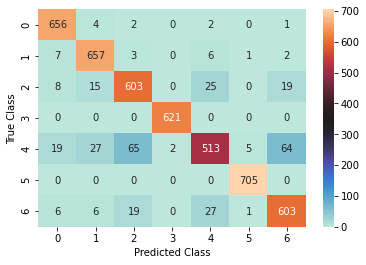

In [133]:
cm = confusion_matrix(y_test,pred_rf)
#sns.heatmap(cm, annot=True)
sns.heatmap(cm, annot=True, fmt='g', vmin=0, cbar=True, cmap='icefire')
plt.ylabel('True Class')
plt.xlabel('Predicted Class')

In [134]:
#Performance metrics from confusion matrix 

FP = cm.sum(axis=0) - np.diag(cm) 
FN = cm.sum(axis=1) - np.diag(cm)
TP = np.diag(cm)
TN = cm.sum() - (FP + FN + TP)

FP = FP.astype(float)
FN = FN.astype(float)
TP = TP.astype(float)
TN = TN.astype(float)

# Sensitivity, hit rate, Recall, or true positive rate
TPR = TP/(TP+FN)

# Specificity or true negative rate
TNR = TN/(TN+FP) 

# Precision or positive predictive value
PPV = TP/(TP+FP)

# Negative predictive value
NPV = TN/(TN+FN)

# Fall out or false positive rate
FPR = FP/(FP+TN)

# False negative rate
FNR = FN/(TP+FN)

# False discovery rate
FDR = FP/(TP+FP)


print('Class:',class_label)

print('Specificity:',TNR)
print('Specificity Mean:',TNR.mean())

print('Class:',class_label)

print('Recall/Sensitivity:',TPR)
print('Recall/Sensitivity Mean:',TPR.mean())

print('Class:',class_label)

print('Precision:',PPV)
print('Precision Mean:',PPV.mean())

Class: {0: 'nv', 1: 'mel', 2: 'bkl', 3: 'bcc', 4: 'akiec', 5: 'vasc', 6: 'df'}
Specificity: [0.99007198 0.98705824 0.9778827  0.99950896 0.98499625 0.99824517
 0.97867063]
Specificity Mean: 0.9880619913615014
Class: {0: 'nv', 1: 'mel', 2: 'bkl', 3: 'bcc', 4: 'akiec', 5: 'vasc', 6: 'df'}
Recall/Sensitivity: [0.98646617 0.97189349 0.9        1.         0.7381295  1.
 0.91087613]
Recall/Sensitivity Mean: 0.9296236122673122
Class: {0: 'nv', 1: 'mel', 2: 'bkl', 3: 'bcc', 4: 'akiec', 5: 'vasc', 6: 'df'}
Precision: [0.94252874 0.92665726 0.87138728 0.99678973 0.89528796 0.99016854
 0.87518142]
Precision Mean: 0.9282858470771437


## XGBoost (Imbalanced data)

In [35]:
from xgboost import XGBClassifier
xgb = XGBClassifier(max_depth=7,n_jobs=-1,booster = "gbtree",num_class = 7,
                    eval_metric = "mlogloss",objective = "multi:softprob")
xgb.fit(X_train, y_train)
pred_xgb = xgb.predict(X_test)
pred2 = xgb.predict(X_train)
print("Accuracy on train: {:.3f}".format(accuracy_score(y_train,pred2)))
print("Accuracy on test: {:.3f}".format(accuracy_score(y_test,pred_xgb)))
print('\n{}'.format(confusion_matrix(y_test,pred_xgb)))

Accuracy on train: 0.995
Accuracy on test: 0.715

[[  6   7   7   0   5   0   3]
 [  5  22   5   0  22   0   3]
 [  3   5  33   0  56   0  11]
 [  0   7   3   0   5   0   0]
 [  0   8  18   0 633   0  19]
 [  0   1   0   0   7   5   1]
 [  0   1  12   0  72   0  17]]


In [36]:
print("xgb:",classification_report(y_test, pred_xgb))

xgb:               precision    recall  f1-score   support

           0       0.43      0.21      0.29        28
           1       0.43      0.39      0.41        57
           2       0.42      0.31      0.35       108
           3       0.00      0.00      0.00        15
           4       0.79      0.93      0.86       678
           5       1.00      0.36      0.53        14
           6       0.31      0.17      0.22       102

    accuracy                           0.71      1002
   macro avg       0.48      0.34      0.38      1002
weighted avg       0.66      0.71      0.68      1002



C:\Users\celie\Anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\celie\Anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\celie\Anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Text(0.5, 15.0, 'Predicted Class')

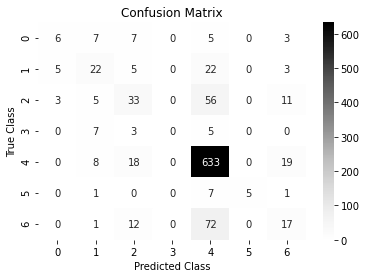

In [37]:
cm = confusion_matrix(y_test,pred_xgb)
#sns.heatmap(cm, annot=True)
sns.heatmap(cm, annot=True, fmt='g', vmin=0, cbar=True, cmap='Greys')
plt.title('Confusion Matrix')
plt.ylabel('True Class')
plt.xlabel('Predicted Class')

In [38]:
#Performance metrics from confusion matrix 

FP = cm.sum(axis=0) - np.diag(cm) 
FN = cm.sum(axis=1) - np.diag(cm)
TP = np.diag(cm)
TN = cm.sum() - (FP + FN + TP)

FP = FP.astype(float)
FN = FN.astype(float)
TP = TP.astype(float)
TN = TN.astype(float)

# Sensitivity, hit rate, Recall, or true positive rate
TPR = TP/(TP+FN)

# Specificity or true negative rate
TNR = TN/(TN+FP) 

# Precision or positive predictive value
PPV = TP/(TP+FP)

# Negative predictive value
NPV = TN/(TN+FN)

# Fall out or false positive rate
FPR = FP/(FP+TN)

# False negative rate
FNR = FN/(TP+FN)

# False discovery rate
FDR = FP/(TP+FP)


print('Class:',class_label)

print('Specificity:',TNR)
print('Specificity Mean:',TNR.mean())

print('Class:',class_label)

print('Recall/Sensitivity:',TPR)
print('Recall/Sensitivity Mean:',TPR.mean())

print('Class:',class_label)

print('Precision:',PPV)
print('Precision Mean:',PPV.mean())

Class: {0: 'nv', 1: 'mel', 2: 'bkl', 3: 'bcc', 4: 'akiec', 5: 'vasc', 6: 'df'}
Specificity: [0.99178645 0.96931217 0.94966443 1.         0.4845679  1.
 0.95888889]
Specificity Mean: 0.9077456909434901
Class: {0: 'nv', 1: 'mel', 2: 'bkl', 3: 'bcc', 4: 'akiec', 5: 'vasc', 6: 'df'}
Recall/Sensitivity: [0.21428571 0.38596491 0.30555556 0.         0.93362832 0.35714286
 0.16666667]
Recall/Sensitivity Mean: 0.3376062892165094
Class: {0: 'nv', 1: 'mel', 2: 'bkl', 3: 'bcc', 4: 'akiec', 5: 'vasc', 6: 'df'}
Precision: [0.42857143 0.43137255 0.42307692        nan 0.79125    1.
 0.31481481]
Precision Mean: nan


C:\Users\celie\Anaconda3\lib\site-packages\ipykernel_launcher.py:20: RuntimeWarning: invalid value encountered in true_divide
C:\Users\celie\Anaconda3\lib\site-packages\ipykernel_launcher.py:32: RuntimeWarning: invalid value encountered in true_divide


### ROC for multi-class classification model, Imbalanced data

In [43]:
from itertools import cycle
from sklearn.metrics import roc_curve, auc
from sklearn.multiclass import OneVsRestClassifier
from scipy import interp
from sklearn.metrics import roc_auc_score


#y_prob = classifier.predict_proba(X_test)

prediction_cplx = xgb.predict_proba(X_test)

macro_roc_auc_ovo = roc_auc_score(y_test, prediction_cplx, multi_class="ovo",
                                  average="macro")
weighted_roc_auc_ovo = roc_auc_score(y_test, prediction_cplx, multi_class="ovo",
                                     average="weighted")
macro_roc_auc_ovr = roc_auc_score(y_test,prediction_cplx, multi_class="ovr",
                                  average="macro")
weighted_roc_auc_ovr = roc_auc_score(y_test, prediction_cplx, multi_class="ovr",
                                     average="weighted")
print("One-vs-One ROC AUC scores:\n{:.6f} (macro),\n{:.6f} "
      "(weighted by prevalence)"
      .format(macro_roc_auc_ovo, weighted_roc_auc_ovo))
print("One-vs-Rest ROC AUC scores:\n{:.6f} (macro),\n{:.6f} "
      "(weighted by prevalence)"
      .format(macro_roc_auc_ovr, weighted_roc_auc_ovr))

One-vs-One ROC AUC scores:
0.821607 (macro),
0.886018 (weighted by prevalence)
One-vs-Rest ROC AUC scores:
0.902199 (macro),
0.891376 (weighted by prevalence)


### ROC plot (imbalanced data)

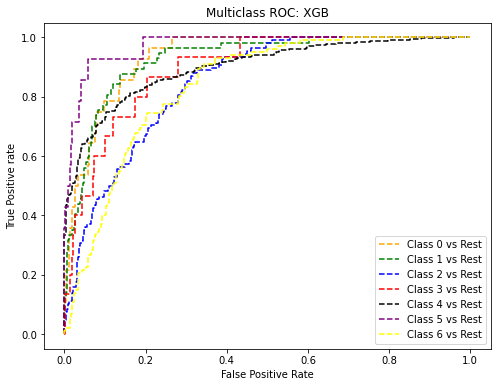

In [42]:
#ROC for multi-class classification model, Imbalanced data 
from sklearn.multiclass import OneVsRestClassifier
from sklearn.metrics import roc_curve
from sklearn.metrics import roc_auc_score

prediction_cplx = xgb.predict_proba(X_test)

# roc curve for classes
fpr = {}
tpr = {}
thresh ={}

n_class = 7

for i in range(n_class):    
    fpr[i], tpr[i], thresh[i] = roc_curve(y_test, prediction_cplx[:,i], pos_label=i)#might have to use proba

#y_score = classifier.fit(X_train, y_train).decision_function(X_test)
# Compute micro-average ROC curve and ROC area
#fpr["micro"], tpr["micro"], _ = roc_curve(y_test.ravel(), y_score.ravel())
#roc_auc["micro"] = auc(fpr["micro"], tpr["micro"])  



    
# plotting
plt.figure(figsize=(8, 6))
plt.plot(fpr[0], tpr[0], linestyle='--',color='orange', label='Class 0 vs Rest')
plt.plot(fpr[1], tpr[1], linestyle='--',color='green', label='Class 1 vs Rest')
plt.plot(fpr[2], tpr[2], linestyle='--',color='blue', label='Class 2 vs Rest')
plt.plot(fpr[3], tpr[3], linestyle='--',color='red', label='Class 3 vs Rest')
plt.plot(fpr[4], tpr[4], linestyle='--',color='black', label='Class 4 vs Rest')
plt.plot(fpr[5], tpr[5], linestyle='--',color='purple', label='Class 5 vs Rest')
plt.plot(fpr[6], tpr[6], linestyle='--',color='yellow', label='Class 6 vs Rest')
plt.title('Multiclass ROC: XGB')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive rate')
plt.legend(loc='best')
plt.savefig('Multiclass ROC',dpi=300); 

## XGBoost (Balanced data)

In [135]:
from xgboost import XGBClassifier
xgb = XGBClassifier(max_depth=7,n_jobs=-1,booster = "gbtree",num_class = 7,
                    eval_metric = "mlogloss",objective = "multi:softprob")
xgb.fit(X_train, y_train)
pred_xgb = xgb.predict(X_test)
pred2 = xgb.predict(X_train)
print("Accuracy on train: {:.3f}".format(accuracy_score(y_train,pred2)))
print("Accuracy on test: {:.3f}".format(accuracy_score(y_test,pred_xgb)))
print('\n{}'.format(confusion_matrix(y_test,pred_xgb)))

Accuracy on train: 0.992
Accuracy on test: 0.950

[[660   1   1   1   2   0   0]
 [  4 662   3   0   1   0   6]
 [  9  11 617   1  10   1  21]
 [  0   1   0 619   0   1   0]
 [  6  14  29   1 566   2  77]
 [  0   0   0   0   0 705   0]
 [  4   0  15   0  11   1 631]]


In [136]:
print("xgb:",classification_report(y_test, pred_xgb))

xgb:               precision    recall  f1-score   support

           0       0.97      0.99      0.98       665
           1       0.96      0.98      0.97       676
           2       0.93      0.92      0.92       670
           3       1.00      1.00      1.00       621
           4       0.96      0.81      0.88       695
           5       0.99      1.00      1.00       705
           6       0.86      0.95      0.90       662

    accuracy                           0.95      4694
   macro avg       0.95      0.95      0.95      4694
weighted avg       0.95      0.95      0.95      4694



Text(0.5, 15.0, 'Predicted Class')

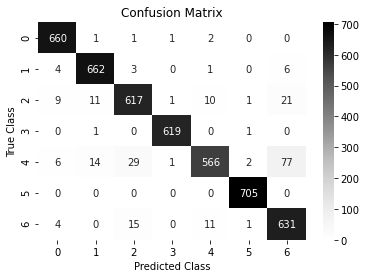

In [137]:
cm = confusion_matrix(y_test,pred_xgb)
#sns.heatmap(cm, annot=True)
sns.heatmap(cm, annot=True, fmt='g', vmin=0, cbar=True, cmap='Greys')
plt.title('Confusion Matrix')
plt.ylabel('True Class')
plt.xlabel('Predicted Class')

In [138]:
#Performance metrics from confusion matrix 

FP = cm.sum(axis=0) - np.diag(cm) 
FN = cm.sum(axis=1) - np.diag(cm)
TP = np.diag(cm)
TN = cm.sum() - (FP + FN + TP)

FP = FP.astype(float)
FN = FN.astype(float)
TP = TP.astype(float)
TN = TN.astype(float)

# Sensitivity, hit rate, Recall, or true positive rate
TPR = TP/(TP+FN)

# Specificity or true negative rate
TNR = TN/(TN+FP) 

# Precision or positive predictive value
PPV = TP/(TP+FP)

# Negative predictive value
NPV = TN/(TN+FN)

# Fall out or false positive rate
FPR = FP/(FP+TN)

# False negative rate
FNR = FN/(TP+FN)

# False discovery rate
FDR = FP/(TP+FP)


print('Class:',class_label)

print('Specificity:',TNR)
print('Specificity Mean:',TNR.mean())

print('Class:',class_label)

print('Recall/Sensitivity:',TPR)
print('Recall/Sensitivity Mean:',TPR.mean())

print('Class:',class_label)

print('Precision:',PPV)
print('Precision Mean:',PPV.mean())

Class: {0: 'nv', 1: 'mel', 2: 'bkl', 3: 'bcc', 4: 'akiec', 5: 'vasc', 6: 'df'}
Specificity: [0.99429139 0.99328024 0.98807157 0.99926344 0.9939985  0.99874655
 0.97420635]
Specificity Mean: 0.9916940058535293
Class: {0: 'nv', 1: 'mel', 2: 'bkl', 3: 'bcc', 4: 'akiec', 5: 'vasc', 6: 'df'}
Recall/Sensitivity: [0.9924812  0.97928994 0.92089552 0.99677939 0.81438849 1.
 0.95317221]
Recall/Sensitivity Mean: 0.9510009641363452
Class: {0: 'nv', 1: 'mel', 2: 'bkl', 3: 'bcc', 4: 'akiec', 5: 'vasc', 6: 'df'}
Precision: [0.96632504 0.96081277 0.92781955 0.99517685 0.95932203 0.99295775
 0.8585034 ]
Precision Mean: 0.95155962688875


### ROC for multi-class classification model, balanced data (SMOTE)

In [140]:
from itertools import cycle
from sklearn.metrics import roc_curve, auc
from sklearn.multiclass import OneVsRestClassifier
from scipy import interp
from sklearn.metrics import roc_auc_score


#y_prob = classifier.predict_proba(X_test)

prediction_cplx = xgb.predict_proba(X_test)

macro_roc_auc_ovo = roc_auc_score(y_test, prediction_cplx, multi_class="ovo",
                                  average="macro")
weighted_roc_auc_ovo = roc_auc_score(y_test, prediction_cplx, multi_class="ovo",
                                     average="weighted")
macro_roc_auc_ovr = roc_auc_score(y_test,prediction_cplx, multi_class="ovr",
                                  average="macro")
weighted_roc_auc_ovr = roc_auc_score(y_test, prediction_cplx, multi_class="ovr",
                                     average="weighted")
print("One-vs-One ROC AUC scores:\n{:.6f} (macro),\n{:.6f} "
      "(weighted by prevalence)"
      .format(macro_roc_auc_ovo, weighted_roc_auc_ovo))
print("One-vs-Rest ROC AUC scores:\n{:.6f} (macro),\n{:.6f} "
      "(weighted by prevalence)"
      .format(macro_roc_auc_ovr, weighted_roc_auc_ovr))

One-vs-One ROC AUC scores:
0.996718 (macro),
0.996681 (weighted by prevalence)
One-vs-Rest ROC AUC scores:
0.996690 (macro),
0.996635 (weighted by prevalence)


### ROC plot

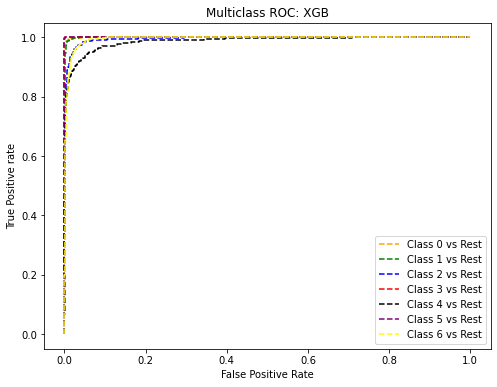

In [141]:
#ROC for multi-class classification model, balanced data (SMOTE) PLOT
from sklearn.multiclass import OneVsRestClassifier
from sklearn.metrics import roc_curve
from sklearn.metrics import roc_auc_score

prediction_cplx = xgb.predict_proba(X_test)

# roc curve for classes
fpr = {}
tpr = {}
thresh ={}

n_class = 7

for i in range(n_class):    
    fpr[i], tpr[i], thresh[i] = roc_curve(y_test, prediction_cplx[:,i], pos_label=i)#might have to use proba

#y_score = classifier.fit(X_train, y_train).decision_function(X_test)
# Compute micro-average ROC curve and ROC area
#fpr["micro"], tpr["micro"], _ = roc_curve(y_test.ravel(), y_score.ravel())
#roc_auc["micro"] = auc(fpr["micro"], tpr["micro"])  



    
# plotting
plt.figure(figsize=(8, 6))
plt.plot(fpr[0], tpr[0], linestyle='--',color='orange', label='Class 0 vs Rest')
plt.plot(fpr[1], tpr[1], linestyle='--',color='green', label='Class 1 vs Rest')
plt.plot(fpr[2], tpr[2], linestyle='--',color='blue', label='Class 2 vs Rest')
plt.plot(fpr[3], tpr[3], linestyle='--',color='red', label='Class 3 vs Rest')
plt.plot(fpr[4], tpr[4], linestyle='--',color='black', label='Class 4 vs Rest')
plt.plot(fpr[5], tpr[5], linestyle='--',color='purple', label='Class 5 vs Rest')
plt.plot(fpr[6], tpr[6], linestyle='--',color='yellow', label='Class 6 vs Rest')
plt.title('Multiclass ROC: XGB')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive rate')
plt.legend(loc='best')
plt.savefig('Multiclass ROC',dpi=300); 

# Neural Network
### Baseline NN (Imbalanced data)

In [20]:
X_test.shape

(1002, 61)

In [21]:
X_train.shape

(9013, 61)

In [22]:
y_test.shape

(1002,)

In [23]:
y_train.shape

(9013,)

In [24]:
n_cols = X_train.shape[1]
n_cols

61

In [76]:
batch_size = 850
num_classes = 7 
epochs = 100

def create_baseline():
    # create model
    model = Sequential()
    model.add(Dense(512, input_dim=(n_cols), activation='relu'))
    model.add(Dense(7, activation='softmax'))
    # Compile model
    model.compile(loss='sparse_categorical_crossentropy', optimizer='adam', metrics=['accuracy'])    
    return model

model = create_baseline()
model.summary()

Model: "sequential_12"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_25 (Dense)             (None, 512)               31744     
_________________________________________________________________
dense_26 (Dense)             (None, 7)                 3591      
Total params: 35,335
Trainable params: 35,335
Non-trainable params: 0
_________________________________________________________________


In [50]:
# evaluate model with standardized dataset
estimator = KerasClassifier(build_fn=create_baseline, 
                            epochs=epochs, batch_size=batch_size, 
                           verbose=0)

kfold = StratifiedKFold(n_splits=4, shuffle=True)

results = cross_val_score(estimator, X_train, y_train, cv=kfold)

In [51]:
print("Baseline: %.2f%% (%.2f%%)" % (results.mean()*100, results.std()*100))

Baseline: 72.71% (0.78%)


In [77]:
history = model.fit(X_train,
                    y_train,
                    epochs=epochs,
                    batch_size=batch_size,
                    verbose=2,
                    validation_data= (X_test,y_test))

Train on 9013 samples, validate on 1002 samples
Epoch 1/100
 - 0s - loss: 2.4102 - accuracy: 0.4309 - val_loss: 1.2190 - val_accuracy: 0.6677
Epoch 2/100
 - 0s - loss: 1.0998 - accuracy: 0.6553 - val_loss: 1.1012 - val_accuracy: 0.6697
Epoch 3/100
 - 0s - loss: 0.8980 - accuracy: 0.7133 - val_loss: 0.9471 - val_accuracy: 0.6836
Epoch 4/100
 - 0s - loss: 0.7777 - accuracy: 0.7314 - val_loss: 0.8911 - val_accuracy: 0.7036
Epoch 5/100
 - 0s - loss: 0.7048 - accuracy: 0.7500 - val_loss: 0.8440 - val_accuracy: 0.7036
Epoch 6/100
 - 0s - loss: 0.6646 - accuracy: 0.7595 - val_loss: 0.8090 - val_accuracy: 0.7206
Epoch 7/100
 - 0s - loss: 0.6335 - accuracy: 0.7708 - val_loss: 0.7976 - val_accuracy: 0.7206
Epoch 8/100
 - 0s - loss: 0.6113 - accuracy: 0.7809 - val_loss: 0.7899 - val_accuracy: 0.7176
Epoch 9/100
 - 0s - loss: 0.5921 - accuracy: 0.7880 - val_loss: 0.7876 - val_accuracy: 0.7206
Epoch 10/100
 - 0s - loss: 0.5759 - accuracy: 0.7941 - val_loss: 0.7727 - val_accuracy: 0.7196
Epoch 11/10

In [78]:
# Print model fitting summury 
score = model.evaluate(X_test, y_test, verbose=0)    
prediction_bl = model.predict_classes(X_test)

print(model.summary())
print('train samples:', X_train.shape[0])
print('test samples:', X_test.shape[0])
print('Test loss:', score[0])
print('Test accuracy:', score[1])

Model: "sequential_12"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_25 (Dense)             (None, 512)               31744     
_________________________________________________________________
dense_26 (Dense)             (None, 7)                 3591      
Total params: 35,335
Trainable params: 35,335
Non-trainable params: 0
_________________________________________________________________
None
train samples: 9013
test samples: 1002
Test loss: 1.0113971949575429
Test accuracy: 0.7325349450111389


In [79]:
print(classification_report(y_test.astype(int), prediction_bl))

              precision    recall  f1-score   support

           0       0.45      0.46      0.46        28
           1       0.51      0.46      0.48        57
           2       0.37      0.33      0.35       108
           3       0.50      0.20      0.29        15
           4       0.84      0.90      0.87       678
           5       0.60      0.64      0.62        14
           6       0.46      0.37      0.41       102

    accuracy                           0.73      1002
   macro avg       0.53      0.48      0.50      1002
weighted avg       0.72      0.73      0.72      1002



Text(0.5, 15.0, 'Predicted Class')

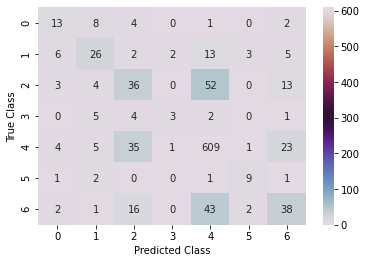

In [80]:
cm = confusion_matrix(y_test,prediction_bl)
#plt.figure(figsize=(10, 10))
sns.heatmap(cm, annot=True, fmt='g', vmin=0, cbar=True, cmap='twilight')
plt.ylabel('True Class')
plt.xlabel('Predicted Class')

In [81]:
#Performance metrics from confusion matrix 

FP = cm.sum(axis=0) - np.diag(cm) 
FN = cm.sum(axis=1) - np.diag(cm)
TP = np.diag(cm)
TN = cm.sum() - (FP + FN + TP)

FP = FP.astype(float)
FN = FN.astype(float)
TP = TP.astype(float)
TN = TN.astype(float)

# Sensitivity, hit rate, Recall, or true positive rate
TPR = TP/(TP+FN)

# Specificity or true negative rate
TNR = TN/(TN+FP) 

# Precision or positive predictive value
PPV = TP/(TP+FP)

# Negative predictive value
NPV = TN/(TN+FN)

# Fall out or false positive rate
FPR = FP/(FP+TN)

# False negative rate
FNR = FN/(TP+FN)

# False discovery rate
FDR = FP/(TP+FP)


print('Class:',class_label)

print('Specificity:',TNR)
print('Specificity Mean:',TNR.mean())

print('Class:',class_label)

print('Recall/Sensitivity:',TPR)
print('Recall/Sensitivity Mean:',TPR.mean())

print('Class:',class_label)

print('Precision:',PPV)
print('Precision Mean:',PPV.mean())

Class: {0: 'nv', 1: 'mel', 2: 'bkl', 3: 'bcc', 4: 'akiec', 5: 'vasc', 6: 'df'}
Specificity: [0.9835729  0.97354497 0.93176734 0.99696049 0.65432099 0.99392713
 0.95      ]
Specificity Mean: 0.9262991151589101
Class: {0: 'nv', 1: 'mel', 2: 'bkl', 3: 'bcc', 4: 'akiec', 5: 'vasc', 6: 'df'}
Recall/Sensitivity: [0.46428571 0.45614035 0.33333333 0.2        0.89823009 0.64285714
 0.37254902]
Recall/Sensitivity Mean: 0.4810565213509716
Class: {0: 'nv', 1: 'mel', 2: 'bkl', 3: 'bcc', 4: 'akiec', 5: 'vasc', 6: 'df'}
Precision: [0.44827586 0.50980392 0.37113402 0.5        0.84466019 0.6
 0.45783133]
Precision Mean: 0.5331007605331588


## Visualize training and test histories

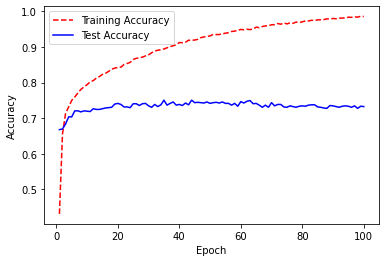

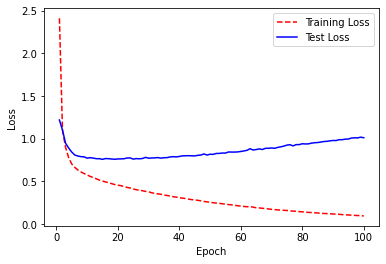

In [82]:
#Get training and test accuracy histories
training_accuracy = history.history['accuracy']
test_accuracy = history.history['val_accuracy']

#Epoch count
epoch_count = range(1,len(training_accuracy) + 1)

#plt.figure(figsize=(8, 6))
plt.plot(epoch_count, training_accuracy, "r--")
plt.plot(epoch_count,test_accuracy, "b-")
plt.legend(['Training Accuracy','Test Accuracy'])
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.show()

#Get training and test loss histories
training_loss = history.history['loss']
test_loss = history.history['val_loss']


#Epoch count
epoch_count = range(1,len(training_loss) + 1)

#Visualize loss history
#plt.figure(figsize=(8, 6))
plt.plot(epoch_count, training_loss, "r--")
plt.plot(epoch_count,test_loss, "b-")
plt.legend(['Training Loss','Test Loss'])
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.show()

### ROC scores for multi-class classification NN Imbalanced data

In [83]:
from itertools import cycle
from sklearn.metrics import roc_curve, auc
from sklearn.multiclass import OneVsRestClassifier
from scipy import interp
from sklearn.metrics import roc_auc_score


#y_prob = classifier.predict_proba(X_test)

prediction_cplx = model.predict_proba(X_test)

macro_roc_auc_ovo = roc_auc_score(y_test, prediction_cplx, multi_class="ovo",
                                  average="macro")
weighted_roc_auc_ovo = roc_auc_score(y_test, prediction_cplx, multi_class="ovo",
                                     average="weighted")
macro_roc_auc_ovr = roc_auc_score(y_test, prediction_cplx, multi_class="ovr",
                                  average="macro")
weighted_roc_auc_ovr = roc_auc_score(y_test, prediction_cplx, multi_class="ovr",
                                     average="weighted")
print("One-vs-One ROC AUC scores:\n{:.6f} (macro),\n{:.6f} "
      "(weighted by prevalence)"
      .format(macro_roc_auc_ovo, weighted_roc_auc_ovo))
print("One-vs-Rest ROC AUC scores:\n{:.6f} (macro),\n{:.6f} "
      "(weighted by prevalence)"
      .format(macro_roc_auc_ovr, weighted_roc_auc_ovr))

One-vs-One ROC AUC scores:
0.841922 (macro),
0.886498 (weighted by prevalence)
One-vs-Rest ROC AUC scores:
0.893305 (macro),
0.875175 (weighted by prevalence)


### ROC plot

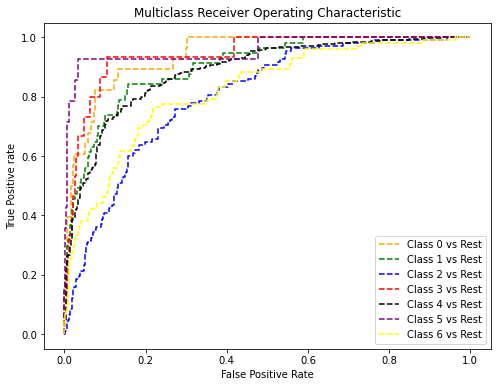

In [84]:
#ROC for multi-class classification model, balanced data (SMOTE)
from sklearn.multiclass import OneVsRestClassifier
from sklearn.metrics import roc_curve
from sklearn.metrics import roc_auc_score

prediction_cplx = model.predict_proba(X_test)

# roc curve for classes
fpr = {}
tpr = {}
thresh ={}

n_class = 7

for i in range(n_class):    
    fpr[i], tpr[i], thresh[i] = roc_curve(y_test, prediction_cplx[:,i], pos_label=i)
    
# plotting
plt.figure(figsize=(8, 6))
plt.plot(fpr[0], tpr[0], linestyle='--',color='orange', label='Class 0 vs Rest')
plt.plot(fpr[1], tpr[1], linestyle='--',color='green', label='Class 1 vs Rest')
plt.plot(fpr[2], tpr[2], linestyle='--',color='blue', label='Class 2 vs Rest')
plt.plot(fpr[3], tpr[3], linestyle='--',color='red', label='Class 3 vs Rest')
plt.plot(fpr[4], tpr[4], linestyle='--',color='black', label='Class 4 vs Rest')
plt.plot(fpr[5], tpr[5], linestyle='--',color='purple', label='Class 5 vs Rest')
plt.plot(fpr[6], tpr[6], linestyle='--',color='yellow', label='Class 6 vs Rest')
plt.title('Multiclass Receiver Operating Characteristic')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive rate')
plt.legend(loc='best')
plt.savefig('Multiclass ROC',dpi=300);

# Neural Network
### Baseline NN (Balanced data)

In [147]:
X_test.shape

(4694, 58)

In [148]:
X_train.shape

(42241, 58)

In [149]:
y_test.shape

(4694,)

In [150]:
y_train.shape

(42241,)

In [151]:
n_cols = X_train.shape[1]
n_cols

58

In [152]:
batch_size = 850
num_classes = 7 
epochs = 100

def create_baseline():
    # create model
    model = Sequential()
    model.add(Dense(512, input_dim=(n_cols), activation='relu'))
    model.add(Dense(7, activation='softmax'))
    # Compile model
    model.compile(loss='sparse_categorical_crossentropy', optimizer='adam', metrics=['accuracy'])    
    return model

model = create_baseline()
model.summary()

Model: "sequential_18"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_38 (Dense)             (None, 512)               30208     
_________________________________________________________________
dense_39 (Dense)             (None, 7)                 3591      
Total params: 33,799
Trainable params: 33,799
Non-trainable params: 0
_________________________________________________________________


In [153]:
# evaluate model with standardized dataset
estimator = KerasClassifier(build_fn=create_baseline, 
                            epochs=epochs, batch_size=batch_size, 
                           verbose=0)

kfold = StratifiedKFold(n_splits=4, shuffle=True)

results = cross_val_score(estimator, X_train, y_train, cv=kfold)

In [154]:
print("Baseline: %.2f%% (%.2f%%)" % (results.mean()*100, results.std()*100))

Baseline: 96.64% (0.16%)


In [155]:
history = model.fit(X_train,
                    y_train,
                    epochs=epochs,
                    batch_size=batch_size,
                    verbose=2,
                    validation_data= (X_test,y_test))

Train on 42241 samples, validate on 4694 samples
Epoch 1/100
 - 1s - loss: 1.3943 - accuracy: 0.5468 - val_loss: 0.8390 - val_accuracy: 0.7265
Epoch 2/100
 - 1s - loss: 0.7351 - accuracy: 0.7599 - val_loss: 0.6469 - val_accuracy: 0.7997
Epoch 3/100
 - 1s - loss: 0.5877 - accuracy: 0.8168 - val_loss: 0.5410 - val_accuracy: 0.8375
Epoch 4/100
 - 1s - loss: 0.4966 - accuracy: 0.8496 - val_loss: 0.4721 - val_accuracy: 0.8581
Epoch 5/100
 - 1s - loss: 0.4274 - accuracy: 0.8760 - val_loss: 0.4155 - val_accuracy: 0.8779
Epoch 6/100
 - 1s - loss: 0.3736 - accuracy: 0.8929 - val_loss: 0.3724 - val_accuracy: 0.8879
Epoch 7/100
 - 1s - loss: 0.3307 - accuracy: 0.9074 - val_loss: 0.3403 - val_accuracy: 0.8994
Epoch 8/100
 - 1s - loss: 0.2948 - accuracy: 0.9178 - val_loss: 0.3065 - val_accuracy: 0.9124
Epoch 9/100
 - 1s - loss: 0.2653 - accuracy: 0.9281 - val_loss: 0.2838 - val_accuracy: 0.9182
Epoch 10/100
 - 1s - loss: 0.2391 - accuracy: 0.9366 - val_loss: 0.2596 - val_accuracy: 0.9222
Epoch 11/1

In [156]:
# Print model fitting summury 
score = model.evaluate(X_test, y_test, verbose=0)    
prediction_bl = model.predict_classes(X_test)

print(model.summary())
print('train samples:', X_train.shape[0])
print('test samples:', X_test.shape[0])
print('Test loss:', score[0])
print('Test accuracy:', score[1])

Model: "sequential_18"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_38 (Dense)             (None, 512)               30208     
_________________________________________________________________
dense_39 (Dense)             (None, 7)                 3591      
Total params: 33,799
Trainable params: 33,799
Non-trainable params: 0
_________________________________________________________________
None
train samples: 42241
test samples: 4694
Test loss: 0.11675094687834249
Test accuracy: 0.9757136702537537


In [157]:
print(classification_report(y_test.astype(int), prediction_bl))

              precision    recall  f1-score   support

           0       0.99      1.00      0.99       665
           1       0.98      1.00      0.99       676
           2       0.96      0.99      0.97       670
           3       1.00      1.00      1.00       621
           4       0.99      0.86      0.92       695
           5       0.99      1.00      1.00       705
           6       0.93      0.99      0.96       662

    accuracy                           0.98      4694
   macro avg       0.98      0.98      0.98      4694
weighted avg       0.98      0.98      0.98      4694



Text(0.5, 15.0, 'Predicted Class')

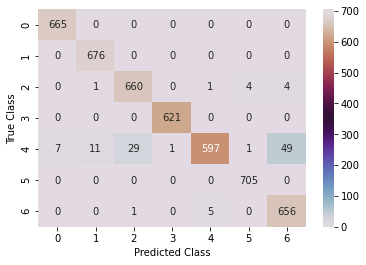

In [158]:
cm = confusion_matrix(y_test,prediction_bl)
#plt.figure(figsize=(10, 10))
sns.heatmap(cm, annot=True, fmt='g', vmin=0, cbar=True, cmap='twilight')
plt.ylabel('True Class')
plt.xlabel('Predicted Class')

In [159]:
#Performance metrics from confusion matrix 

FP = cm.sum(axis=0) - np.diag(cm) 
FN = cm.sum(axis=1) - np.diag(cm)
TP = np.diag(cm)
TN = cm.sum() - (FP + FN + TP)

FP = FP.astype(float)
FN = FN.astype(float)
TP = TP.astype(float)
TN = TN.astype(float)

# Sensitivity, hit rate, Recall, or true positive rate
TPR = TP/(TP+FN)

# Specificity or true negative rate
TNR = TN/(TN+FP) 

# Precision or positive predictive value
PPV = TP/(TP+FP)

# Negative predictive value
NPV = TN/(TN+FN)

# Fall out or false positive rate
FPR = FP/(FP+TN)

# False negative rate
FNR = FN/(TP+FN)

# False discovery rate
FDR = FP/(TP+FP)


print('Class:',class_label)

print('Specificity:',TNR)
print('Specificity Mean:',TNR.mean())

print('Class:',class_label)

print('Recall/Sensitivity:',TPR)
print('Recall/Sensitivity Mean:',TPR.mean())

print('Class:',class_label)

print('Precision:',PPV)
print('Precision Mean:',PPV.mean())

Class: {0: 'nv', 1: 'mel', 2: 'bkl', 3: 'bcc', 4: 'akiec', 5: 'vasc', 6: 'df'}
Specificity: [0.9982626  0.99701344 0.99254473 0.99975448 0.99849962 0.99874655
 0.98685516]
Specificity Mean: 0.9959537978134472
Class: {0: 'nv', 1: 'mel', 2: 'bkl', 3: 'bcc', 4: 'akiec', 5: 'vasc', 6: 'df'}
Recall/Sensitivity: [1.         1.         0.98507463 1.         0.85899281 1.
 0.99093656]
Recall/Sensitivity Mean: 0.9764291412160436
Class: {0: 'nv', 1: 'mel', 2: 'bkl', 3: 'bcc', 4: 'akiec', 5: 'vasc', 6: 'df'}
Precision: [0.98958333 0.98255814 0.95652174 0.99839228 0.99004975 0.99295775
 0.92524683]
Precision Mean: 0.9764728313136751


## Visualize training and test histories

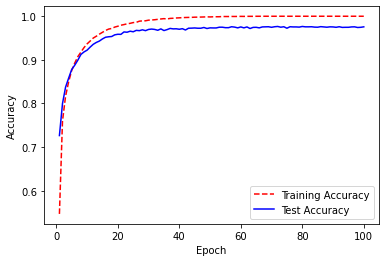

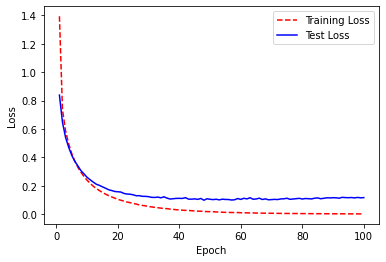

In [160]:
#Get training and test accuracy histories
training_accuracy = history.history['accuracy']
test_accuracy = history.history['val_accuracy']

#Epoch count
epoch_count = range(1,len(training_accuracy) + 1)

#plt.figure(figsize=(8, 6))
plt.plot(epoch_count, training_accuracy, "r--")
plt.plot(epoch_count,test_accuracy, "b-")
plt.legend(['Training Accuracy','Test Accuracy'])
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.show()

#Get training and test loss histories
training_loss = history.history['loss']
test_loss = history.history['val_loss']


#Epoch count
epoch_count = range(1,len(training_loss) + 1)

#Visualize loss history
#plt.figure(figsize=(8, 6))
plt.plot(epoch_count, training_loss, "r--")
plt.plot(epoch_count,test_loss, "b-")
plt.legend(['Training Loss','Test Loss'])
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.show()

### ROC scores for multi-class classification model (Balanced data)

In [161]:
from itertools import cycle
from sklearn.metrics import roc_curve, auc
from sklearn.multiclass import OneVsRestClassifier
from scipy import interp
from sklearn.metrics import roc_auc_score


#y_prob = classifier.predict_proba(X_test)

prediction_cplx = model.predict_proba(X_test)

macro_roc_auc_ovo = roc_auc_score(y_test, prediction_cplx, multi_class="ovo",
                                  average="macro")
weighted_roc_auc_ovo = roc_auc_score(y_test, prediction_cplx, multi_class="ovo",
                                     average="weighted")
macro_roc_auc_ovr = roc_auc_score(y_test, prediction_cplx, multi_class="ovr",
                                  average="macro")
weighted_roc_auc_ovr = roc_auc_score(y_test, prediction_cplx, multi_class="ovr",
                                     average="weighted")
print("One-vs-One ROC AUC scores:\n{:.6f} (macro),\n{:.6f} "
      "(weighted by prevalence)"
      .format(macro_roc_auc_ovo, weighted_roc_auc_ovo))
print("One-vs-Rest ROC AUC scores:\n{:.6f} (macro),\n{:.6f} "
      "(weighted by prevalence)"
      .format(macro_roc_auc_ovr, weighted_roc_auc_ovr))

One-vs-One ROC AUC scores:
0.997030 (macro),
0.996990 (weighted by prevalence)
One-vs-Rest ROC AUC scores:
0.997011 (macro),
0.996937 (weighted by prevalence)


### ROC plot

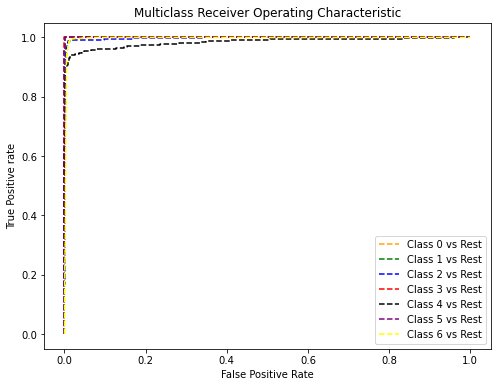

In [162]:
#ROC for multi-class classification model, balanced data (SMOTE)
from sklearn.multiclass import OneVsRestClassifier
from sklearn.metrics import roc_curve
from sklearn.metrics import roc_auc_score

prediction_cplx = model.predict_proba(X_test)

# roc curve for classes
fpr = {}
tpr = {}
thresh ={}

n_class = 7

for i in range(n_class):    
    fpr[i], tpr[i], thresh[i] = roc_curve(y_test, prediction_cplx[:,i], pos_label=i)
    
# plotting
plt.figure(figsize=(8, 6))
plt.plot(fpr[0], tpr[0], linestyle='--',color='orange', label='Class 0 vs Rest')
plt.plot(fpr[1], tpr[1], linestyle='--',color='green', label='Class 1 vs Rest')
plt.plot(fpr[2], tpr[2], linestyle='--',color='blue', label='Class 2 vs Rest')
plt.plot(fpr[3], tpr[3], linestyle='--',color='red', label='Class 3 vs Rest')
plt.plot(fpr[4], tpr[4], linestyle='--',color='black', label='Class 4 vs Rest')
plt.plot(fpr[5], tpr[5], linestyle='--',color='purple', label='Class 5 vs Rest')
plt.plot(fpr[6], tpr[6], linestyle='--',color='yellow', label='Class 6 vs Rest')
plt.title('Multiclass Receiver Operating Characteristic')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive rate')
plt.legend(loc='best')
plt.savefig('Multiclass ROC',dpi=300);

## Increased model complexity (Imbalanced data)
#### Added an extra layer with 64 units, Dropout of .20 and Early Stopping

In [76]:
X_train.shape

(42241, 59)

In [78]:
X_test.shape

(4694, 59)

In [79]:
y_train.shape

(42241,)

In [80]:
y_test.shape

(4694,)

In [82]:
n_cols = X_train.shape[1]
n_cols

59

In [46]:
batch_size = 850
num_classes = 7 
epochs = 100
es = EarlyStopping(monitor='val_loss', mode='auto', patience=10,restore_best_weights=True,
 verbose=1)

def create_cplx():
    
    #Create model
    model = Sequential()
    model.add(Dense(512, activation='relu', input_shape=(n_cols,))) 
    model.add(Dense(64, activation='relu'))
    model.add(Dropout(0.20)) 
    model.add(Dense(7, activation='softmax'))

    model.compile(loss='sparse_categorical_crossentropy', optimizer='adam', metrics=['accuracy'])    
    return model
   

model = create_cplx()
model.summary()

Model: "sequential_19"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_55 (Dense)             (None, 512)               31744     
_________________________________________________________________
dense_56 (Dense)             (None, 64)                32832     
_________________________________________________________________
dropout_19 (Dropout)         (None, 64)                0         
_________________________________________________________________
dense_57 (Dense)             (None, 7)                 455       
Total params: 65,031
Trainable params: 65,031
Non-trainable params: 0
_________________________________________________________________


In [47]:
#evaluate model with standardized dataset
estimator = KerasClassifier(build_fn=create_cplx, 
                           epochs=epochs, batch_size=batch_size, 
                           verbose=0)

kfold = StratifiedKFold(n_splits=4, shuffle=True)

results = cross_val_score(estimator, X_train, y_train, cv=kfold)

In [48]:
print("Larger: %.2f%% (%.2f%%)" % (results.mean()*100, results.std()*100))

Larger: 73.60% (0.62%)


In [49]:
history = model.fit(X_train, y_train, 
                  batch_size=batch_size,
                  epochs=epochs,
                  callbacks=[es],
                  verbose=1,
                  validation_data=(X_test, y_test))

Train on 9013 samples, validate on 1002 samples
Epoch 1/100
9013/9013 [==============================] - 1s 75us/step - loss: 1.9160 - accuracy: 0.5474 - val_loss: 1.1311 - val_accuracy: 0.5908
Epoch 2/100
9013/9013 [==============================] - 0s 21us/step - loss: 1.0412 - accuracy: 0.6401 - val_loss: 0.9110 - val_accuracy: 0.6976
Epoch 3/100
9013/9013 [==============================] - 0s 21us/step - loss: 0.8856 - accuracy: 0.6978 - val_loss: 0.8415 - val_accuracy: 0.7066
Epoch 4/100
9013/9013 [==============================] - 0s 20us/step - loss: 0.8260 - accuracy: 0.7071 - val_loss: 0.8079 - val_accuracy: 0.7196
Epoch 5/100
9013/9013 [==============================] - 0s 20us/step - loss: 0.7757 - accuracy: 0.7227 - val_loss: 0.7933 - val_accuracy: 0.7206
Epoch 6/100
9013/9013 [==============================] - 0s 20us/step - loss: 0.7442 - accuracy: 0.7293 - val_loss: 0.7848 - val_accuracy: 0.7156
Epoch 7/100
9013/9013 [==============================] - 0s 22us/step - loss

In [50]:
# Print model fitting summury 
score = model.evaluate(X_test, y_test, verbose=0)
prediction_cplx = model.predict_classes(X_test)

print(model.summary())
print('train samples:', X_train.shape[0])
print('test samples:', X_test.shape[0])
print('Test loss:', score[0])
print('Test accuracy:', score[1])

Model: "sequential_19"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_55 (Dense)             (None, 512)               31744     
_________________________________________________________________
dense_56 (Dense)             (None, 64)                32832     
_________________________________________________________________
dropout_19 (Dropout)         (None, 64)                0         
_________________________________________________________________
dense_57 (Dense)             (None, 7)                 455       
Total params: 65,031
Trainable params: 65,031
Non-trainable params: 0
_________________________________________________________________
None
train samples: 9013
test samples: 1002
Test loss: 0.7389598348421489
Test accuracy: 0.7335329055786133


In [51]:
print(classification_report(y_test.astype(int), prediction_cplx))

              precision    recall  f1-score   support

           0       0.47      0.25      0.33        28
           1       0.45      0.53      0.48        57
           2       0.48      0.39      0.43       108
           3       0.00      0.00      0.00        15
           4       0.82      0.92      0.87       678
           5       0.50      0.29      0.36        14
           6       0.46      0.26      0.34       102

    accuracy                           0.73      1002
   macro avg       0.45      0.38      0.40      1002
weighted avg       0.70      0.73      0.71      1002



C:\Users\celie\Anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\celie\Anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\celie\Anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Text(0.5, 15.0, 'Predicted Class')

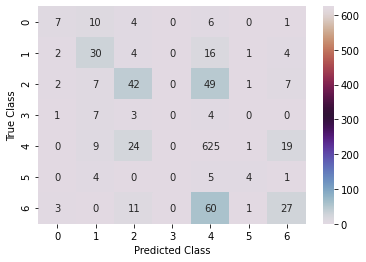

In [52]:
cm = confusion_matrix(y_test,prediction_cplx)
#plt.figure(figsize=(10, 10))
sns.heatmap(cm, annot=True, fmt='g', vmin=0, cbar=True, cmap='twilight')
plt.ylabel('True Class')
plt.xlabel('Predicted Class')

In [55]:
#Performance metrics from confusion matrix 

FP = cm.sum(axis=0) - np.diag(cm) 
FN = cm.sum(axis=1) - np.diag(cm)
TP = np.diag(cm)
TN = cm.sum() - (FP + FN + TP)

FP = FP.astype(float)
FN = FN.astype(float)
TP = TP.astype(float)
TN = TN.astype(float)

# Sensitivity, hit rate, Recall, or true positive rate
TPR = TP/(TP+FN)

# Specificity or true negative rate
TNR = TN/(TN+FP) 

# Precision or positive predictive value
PPV = TP/(TP+FP)

# Negative predictive value
NPV = TN/(TN+FN)

# Fall out or false positive rate
FPR = FP/(FP+TN)

# False negative rate
FNR = FN/(TP+FN)

# False discovery rate
FDR = FP/(TP+FP)


print('Class:',class_label)

print('Specificity:',TNR)
print('Specificity Mean:',TNR.mean())

print('Class:',class_label)

print('Recall/Sensitivity:',TPR)
print('Recall/Sensitivity Mean:',TPR.mean())

print('Class:',class_label)

print('Precision:',PPV)
print('Precision Mean:',PPV.mean())

Class: {0: 'nv', 1: 'mel', 2: 'bkl', 3: 'bcc', 4: 'akiec', 5: 'vasc', 6: 'df'}
Specificity: [0.99178645 0.96084656 0.94854586 1.         0.56790123 0.99595142
 0.96444444]
Specificity Mean: 0.9184965665427284
Class: {0: 'nv', 1: 'mel', 2: 'bkl', 3: 'bcc', 4: 'akiec', 5: 'vasc', 6: 'df'}
Recall/Sensitivity: [0.25       0.52631579 0.38888889 0.         0.92182891 0.28571429
 0.26470588]
Recall/Sensitivity Mean: 0.3767791078549103
Class: {0: 'nv', 1: 'mel', 2: 'bkl', 3: 'bcc', 4: 'akiec', 5: 'vasc', 6: 'df'}
Precision: [0.46666667 0.44776119 0.47727273        nan 0.81699346 0.5
 0.45762712]
Precision Mean: nan


C:\Users\celie\Anaconda3\lib\site-packages\ipykernel_launcher.py:20: RuntimeWarning: invalid value encountered in true_divide
C:\Users\celie\Anaconda3\lib\site-packages\ipykernel_launcher.py:32: RuntimeWarning: invalid value encountered in true_divide


## Visualize training and test histories

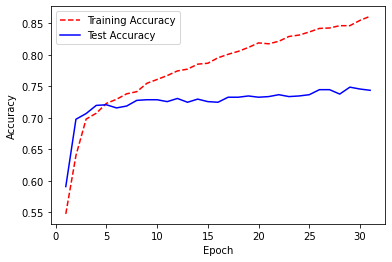

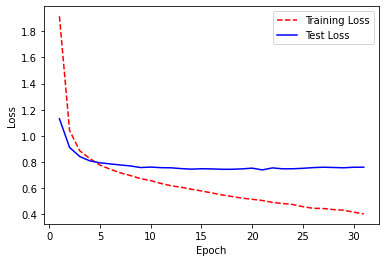

In [56]:
#Get training and test accuracy histories
training_accuracy = history.history['accuracy']
test_accuracy = history.history['val_accuracy']

#Epoch count
epoch_count = range(1,len(training_accuracy) + 1)

#plt.figure(figsize=(8, 6))
plt.plot(epoch_count, training_accuracy, "r--")
plt.plot(epoch_count,test_accuracy, "b-")
plt.legend(['Training Accuracy','Test Accuracy'])
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.show()

#Get training and test loss histories
training_loss = history.history['loss']
test_loss = history.history['val_loss']


#Epoch count
epoch_count = range(1,len(training_loss) + 1)

#Visualize loss history
#plt.figure(figsize=(8, 6))
plt.plot(epoch_count, training_loss, "r--")
plt.plot(epoch_count,test_loss, "b-")
plt.legend(['Training Loss','Test Loss'])
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.show()

### ROC scores for multi-class classification model

In [57]:
from itertools import cycle
from sklearn.metrics import roc_curve, auc
from sklearn.multiclass import OneVsRestClassifier
from scipy import interp
from sklearn.metrics import roc_auc_score


#y_prob = classifier.predict_proba(X_test)

prediction_cplx = model.predict_proba(X_test)

macro_roc_auc_ovo = roc_auc_score(y_test, prediction_cplx, multi_class="ovo",
                                  average="macro")
weighted_roc_auc_ovo = roc_auc_score(y_test, prediction_cplx, multi_class="ovo",
                                     average="weighted")
macro_roc_auc_ovr = roc_auc_score(y_test, prediction_cplx, multi_class="ovr",
                                  average="macro")
weighted_roc_auc_ovr = roc_auc_score(y_test, prediction_cplx, multi_class="ovr",
                                     average="weighted")
print("One-vs-One ROC AUC scores:\n{:.6f} (macro),\n{:.6f} "
      "(weighted by prevalence)"
      .format(macro_roc_auc_ovo, weighted_roc_auc_ovo))
print("One-vs-Rest ROC AUC scores:\n{:.6f} (macro),\n{:.6f} "
      "(weighted by prevalence)"
      .format(macro_roc_auc_ovr, weighted_roc_auc_ovr))

One-vs-One ROC AUC scores:
0.831828 (macro),
0.889171 (weighted by prevalence)
One-vs-Rest ROC AUC scores:
0.901861 (macro),
0.884384 (weighted by prevalence)


### ROC plot

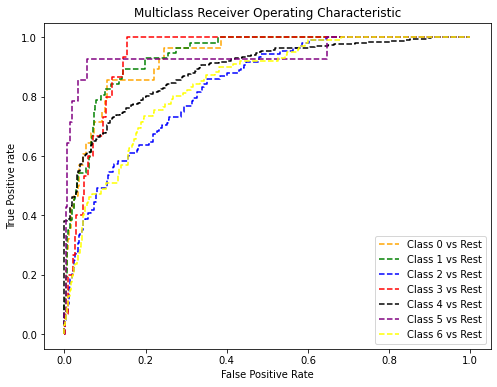

In [58]:
#ROC for multi-class classification model, balanced data (SMOTE)
from sklearn.multiclass import OneVsRestClassifier
from sklearn.metrics import roc_curve
from sklearn.metrics import roc_auc_score

prediction_cplx = model.predict_proba(X_test)

# roc curve for classes
fpr = {}
tpr = {}
thresh ={}

n_class = 7

for i in range(n_class):    
    fpr[i], tpr[i], thresh[i] = roc_curve(y_test, prediction_cplx[:,i], pos_label=i)
    
# plotting
plt.figure(figsize=(8, 6))
plt.plot(fpr[0], tpr[0], linestyle='--',color='orange', label='Class 0 vs Rest')
plt.plot(fpr[1], tpr[1], linestyle='--',color='green', label='Class 1 vs Rest')
plt.plot(fpr[2], tpr[2], linestyle='--',color='blue', label='Class 2 vs Rest')
plt.plot(fpr[3], tpr[3], linestyle='--',color='red', label='Class 3 vs Rest')
plt.plot(fpr[4], tpr[4], linestyle='--',color='black', label='Class 4 vs Rest')
plt.plot(fpr[5], tpr[5], linestyle='--',color='purple', label='Class 5 vs Rest')
plt.plot(fpr[6], tpr[6], linestyle='--',color='yellow', label='Class 6 vs Rest')
plt.title('Multiclass Receiver Operating Characteristic')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive rate')
plt.legend(loc='best')
plt.savefig('Multiclass ROC',dpi=300);

## Increased model complexity (Balanced data)
#### Added an extra layer with 64 units, Dropout of .20 and Early Stopping

In [90]:
batch_size = 850
num_classes = 7 
epochs = 100
es = EarlyStopping(monitor='val_loss', mode='auto', patience=10,restore_best_weights=True,
 verbose=1)

def create_cplx():
    
    #Create model
    model = Sequential()
    model.add(Dense(512, activation='relu', input_shape=(n_cols,))) 
    model.add(Dense(64, activation='relu'))
    model.add(Dropout(0.20)) 
    model.add(Dense(7, activation='softmax'))


    model.compile(loss='sparse_categorical_crossentropy', optimizer='adam',metrics=['accuracy'])
    return model
 
    
model = create_cplx()
model.summary()

Model: "sequential_24"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_70 (Dense)             (None, 512)               30720     
_________________________________________________________________
dense_71 (Dense)             (None, 64)                32832     
_________________________________________________________________
dropout_24 (Dropout)         (None, 64)                0         
_________________________________________________________________
dense_72 (Dense)             (None, 7)                 455       
Total params: 64,007
Trainable params: 64,007
Non-trainable params: 0
_________________________________________________________________


In [91]:
#evaluate model with standardized dataset
estimator = KerasClassifier(build_fn = create_cplx, 
                           epochs=epochs, batch_size=batch_size, 
                           verbose=0)

kfold = StratifiedKFold(n_splits=4, shuffle=True)

results = cross_val_score(estimator, X_train, y_train, cv=kfold)

In [92]:
print("Larger: %.2f%% (%.2f%%)" % (results.mean()*100, results.std()*100))

Larger: 96.99% (0.10%)


In [93]:
history = model.fit(X_train, y_train, 
                  batch_size=batch_size,
                  epochs=epochs,
                  callbacks=[es],
                  verbose=1,
                  validation_data=(X_test, y_test))

Train on 42241 samples, validate on 4694 samples
Epoch 1/100
42241/42241 [==============================] - 1s 33us/step - loss: 1.4272 - accuracy: 0.5049 - val_loss: 0.8670 - val_accuracy: 0.7199
Epoch 2/100
42241/42241 [==============================] - 1s 20us/step - loss: 0.8161 - accuracy: 0.7187 - val_loss: 0.6151 - val_accuracy: 0.8049
Epoch 3/100
42241/42241 [==============================] - 1s 20us/step - loss: 0.6187 - accuracy: 0.7902 - val_loss: 0.4926 - val_accuracy: 0.8406
Epoch 4/100
42241/42241 [==============================] - 1s 20us/step - loss: 0.5070 - accuracy: 0.8289 - val_loss: 0.4174 - val_accuracy: 0.8692
Epoch 5/100
42241/42241 [==============================] - 1s 20us/step - loss: 0.4297 - accuracy: 0.8561 - val_loss: 0.3567 - val_accuracy: 0.8894
Epoch 6/100
42241/42241 [==============================] - 1s 20us/step - loss: 0.3703 - accuracy: 0.8751 - val_loss: 0.3099 - val_accuracy: 0.9012
Epoch 7/100
42241/42241 [==============================] - 1s 2

In [94]:
# Print model fitting summury 
score = model.evaluate(X_test, y_test, verbose=0)
prediction_cplx = model.predict_classes(X_test)

print(model.summary())
print('train samples:', X_train.shape[0])
print('test samples:', X_test.shape[0])
print('Test loss:', score[0])
print('Test accuracy:', score[1])

Model: "sequential_24"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_70 (Dense)             (None, 512)               30720     
_________________________________________________________________
dense_71 (Dense)             (None, 64)                32832     
_________________________________________________________________
dropout_24 (Dropout)         (None, 64)                0         
_________________________________________________________________
dense_72 (Dense)             (None, 7)                 455       
Total params: 64,007
Trainable params: 64,007
Non-trainable params: 0
_________________________________________________________________
None
train samples: 42241
test samples: 4694
Test loss: 0.08462381188793035
Test accuracy: 0.9774180054664612


In [95]:
print(classification_report(y_test.astype(int), prediction_cplx))

              precision    recall  f1-score   support

           0       0.99      1.00      1.00       665
           1       0.99      1.00      0.99       676
           2       0.95      0.98      0.97       670
           3       1.00      1.00      1.00       621
           4       0.97      0.88      0.92       695
           5       1.00      1.00      1.00       705
           6       0.94      0.98      0.96       662

    accuracy                           0.98      4694
   macro avg       0.98      0.98      0.98      4694
weighted avg       0.98      0.98      0.98      4694



Text(0.5, 15.0, 'Predicted Class')

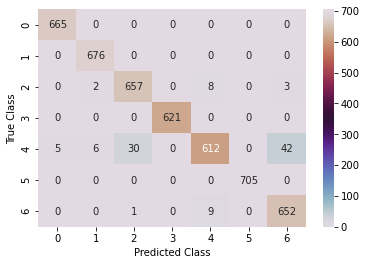

In [96]:
cm = confusion_matrix(y_test,prediction_cplx)
#plt.figure(figsize=(10, 10))
sns.heatmap(cm, annot=True, fmt='g', vmin=0, cbar=True, cmap='twilight')
plt.ylabel('True Class')
plt.xlabel('Predicted Class')

In [97]:
#Performance metrics from confusion matrix 

FP = cm.sum(axis=0) - np.diag(cm) 
FN = cm.sum(axis=1) - np.diag(cm)
TP = np.diag(cm)
TN = cm.sum() - (FP + FN + TP)

FP = FP.astype(float)
FN = FN.astype(float)
TP = TP.astype(float)
TN = TN.astype(float)

# Sensitivity, hit rate, Recall, or true positive rate
TPR = TP/(TP+FN)

# Specificity or true negative rate
TNR = TN/(TN+FP) 

# Precision or positive predictive value
PPV = TP/(TP+FP)

# Negative predictive value
NPV = TN/(TN+FN)

# Fall out or false positive rate
FPR = FP/(FP+TN)

# False negative rate
FNR = FN/(TP+FN)

# False discovery rate
FDR = FP/(TP+FP)


print('Class:',class_label)

print('Specificity:',TNR)
print('Specificity Mean:',TNR.mean())

print('Class:',class_label)

print('Recall/Sensitivity:',TPR)
print('Recall/Sensitivity Mean:',TPR.mean())

print('Class:',class_label)

print('Precision:',PPV)
print('Precision Mean:',PPV.mean())

Class: {0: 'nv', 1: 'mel', 2: 'bkl', 3: 'bcc', 4: 'akiec', 5: 'vasc', 6: 'df'}
Specificity: [0.998759   0.99800896 0.99229622 1.         0.99574894 1.
 0.98883929]
Specificity Mean: 0.9962360575091197
Class: {0: 'nv', 1: 'mel', 2: 'bkl', 3: 'bcc', 4: 'akiec', 5: 'vasc', 6: 'df'}
Recall/Sensitivity: [1.         1.         0.98059701 1.         0.88057554 1.
 0.98489426]
Recall/Sensitivity Mean: 0.9780095449017784
Class: {0: 'nv', 1: 'mel', 2: 'bkl', 3: 'bcc', 4: 'akiec', 5: 'vasc', 6: 'df'}
Precision: [0.99253731 0.98830409 0.95494186 1.         0.97297297 1.
 0.93543759]
Precision Mean: 0.9777419757297415


## Visualize training and test histories

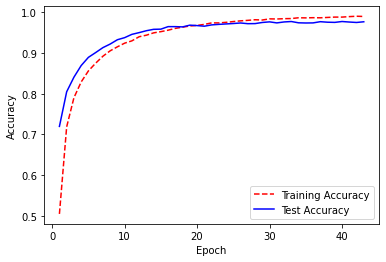

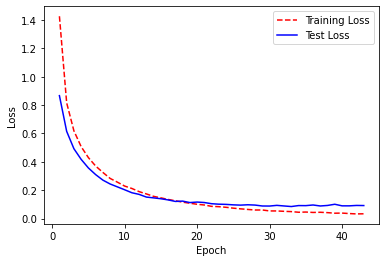

In [98]:
#Get training and test accuracy histories
training_accuracy = history.history['accuracy']
test_accuracy = history.history['val_accuracy']

#Epoch count
epoch_count = range(1,len(training_accuracy) + 1)

#plt.figure(figsize=(8, 6))
plt.plot(epoch_count, training_accuracy, "r--")
plt.plot(epoch_count,test_accuracy, "b-")
plt.legend(['Training Accuracy','Test Accuracy'])
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.show()

#Get training and test loss histories
training_loss = history.history['loss']
test_loss = history.history['val_loss']


#Epoch count
epoch_count = range(1,len(training_loss) + 1)

#Visualize loss history
#plt.figure(figsize=(8, 6))
plt.plot(epoch_count, training_loss, "r--")
plt.plot(epoch_count,test_loss, "b-")
plt.legend(['Training Loss','Test Loss'])
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.show()

### ROC scores for multi-class classification model

In [99]:
from itertools import cycle
from sklearn.metrics import roc_curve, auc
from sklearn.multiclass import OneVsRestClassifier
from scipy import interp
from sklearn.metrics import roc_auc_score


#y_prob = classifier.predict_proba(X_test)

prediction_cplx = model.predict_proba(X_test)

macro_roc_auc_ovo = roc_auc_score(y_test, prediction_cplx, multi_class="ovo",
                                  average="macro")
weighted_roc_auc_ovo = roc_auc_score(y_test, prediction_cplx, multi_class="ovo",
                                     average="weighted")
macro_roc_auc_ovr = roc_auc_score(y_test, prediction_cplx, multi_class="ovr",
                                  average="macro")
weighted_roc_auc_ovr = roc_auc_score(y_test, prediction_cplx, multi_class="ovr",
                                     average="weighted")
print("One-vs-One ROC AUC scores:\n{:.6f} (macro),\n{:.6f} "
      "(weighted by prevalence)"
      .format(macro_roc_auc_ovo, weighted_roc_auc_ovo))
print("One-vs-Rest ROC AUC scores:\n{:.6f} (macro),\n{:.6f} "
      "(weighted by prevalence)"
      .format(macro_roc_auc_ovr, weighted_roc_auc_ovr))

One-vs-One ROC AUC scores:
0.997727 (macro),
0.997695 (weighted by prevalence)
One-vs-Rest ROC AUC scores:
0.997708 (macro),
0.997654 (weighted by prevalence)


### ROC plot

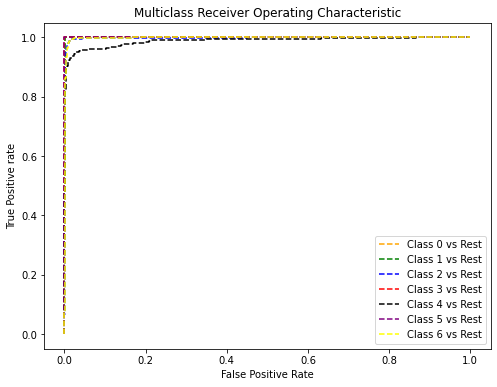

In [100]:
#ROC for multi-class classification model, balanced data (SMOTE)
from sklearn.multiclass import OneVsRestClassifier
from sklearn.metrics import roc_curve
from sklearn.metrics import roc_auc_score

prediction_cplx = model.predict_proba(X_test)

# roc curve for classes
fpr = {}
tpr = {}
thresh ={}

n_class = 7

for i in range(n_class):    
    fpr[i], tpr[i], thresh[i] = roc_curve(y_test, prediction_cplx[:,i], pos_label=i)
    
# plotting
plt.figure(figsize=(8, 6))
plt.plot(fpr[0], tpr[0], linestyle='--',color='orange', label='Class 0 vs Rest')
plt.plot(fpr[1], tpr[1], linestyle='--',color='green', label='Class 1 vs Rest')
plt.plot(fpr[2], tpr[2], linestyle='--',color='blue', label='Class 2 vs Rest')
plt.plot(fpr[3], tpr[3], linestyle='--',color='red', label='Class 3 vs Rest')
plt.plot(fpr[4], tpr[4], linestyle='--',color='black', label='Class 4 vs Rest')
plt.plot(fpr[5], tpr[5], linestyle='--',color='purple', label='Class 5 vs Rest')
plt.plot(fpr[6], tpr[6], linestyle='--',color='yellow', label='Class 6 vs Rest')
plt.title('Multiclass Receiver Operating Characteristic')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive rate')
plt.legend(loc='best')
plt.savefig('Multiclass ROC',dpi=300);

### 4. Make a Prediction from an image not in the original dataset
A new image of a skin lesion is gathered from an outside source and not from the dataset used for training and testing.

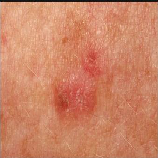

In [101]:
from keras.preprocessing import image

img_path = ('C:/Users/celie/Desktop/acct2.jpg')
img = image.load_img(img_path, target_size=(158,158))
img

In [109]:
# Classify image not in the dataset
import cv2
img = cv2.imread('C:/Users/celie/Desktop/acct2.jpg',0)


img = cv2.resize(img,(59,59))
#plt.imshow(img)
#img = np.reshape(img,[-1,56,56,3])
cv2.waitKey(0)
cv2.destroyAllWindows()

print(class_label)

prediction_cplx = model.predict_classes(img)

print('The predicted class of the lesion is:', prediction_cplx[1])

{0: 'nv', 1: 'mel', 2: 'bkl', 3: 'bcc', 4: 'akiec', 5: 'vasc', 6: 'df'}
The predicted class of the lesion is: 5


### Save Best Model

In [110]:
model.save('hamskin_1_59_59.h5')

In [119]:
reconstructed_model = keras.models.load_model('hamskin_1_59_59.h5')
reconstructed_model.summary()

Model: "sequential_24"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_70 (Dense)             (None, 512)               30720     
_________________________________________________________________
dense_71 (Dense)             (None, 64)                32832     
_________________________________________________________________
dropout_24 (Dropout)         (None, 64)                0         
_________________________________________________________________
dense_72 (Dense)             (None, 7)                 455       
Total params: 64,007
Trainable params: 64,007
Non-trainable params: 0
_________________________________________________________________


In [127]:
!ls -ltr hamskin_1_*

-rw-r--r-- 1 celie celie 795456 Jun  3 13:48 hamskin_1_59_59.h5
